# Limpieza de datos y selección de características

### Curso Intermedio de Aprendizaje Automático 2021

**Vanessa Gómez Verdejo, Emilio Parrado Hernández,  Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />


En esta sesión vamos a utilizar nuestro conocimiento sobre el análisis exploratorio de datos, para reconocer los problemas que pueda haber en nuestros datos y solventarlos de la mejor manera posible.
Es decir, una vez que detectemos problemas en nuestros datos, en lugar de eliminar inmediatamente las filas/columnas, debemos pensar en las mejores formas de solucionar estos problemas. La mayoría de las veces, el rendimiento final de nuestra máquina  de aprendizaje nos lo agradecerá.

En este notebook exploraremos tres técnicas para preparar/mejorar nuestros conjuntos de datos antes de usarlos en nuestro pipeline de aprendizaje. En particular, revisaremos:
* cómo lidiar con los valores perdidos: **imputación de valores perdidos**.
* cómo limpiar nuestros datos de los valores atípicos: **detección de outliers**.
* cómo detectar qué características son realmente relevantes para la tarea final: **selección de características**.

In [54]:
from IPython.core.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [55]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Configuración de las figuras matplotlib
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 8})

# 1. Imputación de valores perdidos

Cuando tenemos que enfrentarnos a problemas reales es bastante común encontrar que nuestros conjuntos de datos contienen valores perdidos, a menudo codificados como `?`, `nan`, `N/A`, celda en blanco, o a veces `-999`, `inf`, `-inf`. El uso de estos conjuntos de datos para entrenar modelos de aprendizaje automático presenta problemas ya que, en general, los métodos `fit`, `predict`, `transform`, etc, esperan como argumentos de entrada arrays con valores numéricos. 

Una estrategia inmediata para usar estos conjuntos de datos sería descartar las filas y/o columnas que contengan valores perdidos. Sin embargo, esto se hace a costa de perder datos que pueden ser valiosos (aunque estén incompletos). Una mejor estrategia es **imputar** los valores perdidos, es decir, inferirlos a partir de la parte conocida de los datos. 

Además, si los valores perdidos están en los datos sobre los que queremos hacer nuestras predicciones (conjunto de test), no podemos permitirlos descartarlos. En este caso, es necesario imputar estos valores perdidos para poder obtener la salida de la máquina para ellos.


El objetivo de esta sección es introducir algunos de los métodos básicos para manejar valores perdidos. Para ello, utilizaremos el conjunto de datos `tips` que se encuentra en la libreria `seaborn`, incluyendo al azar algunos valores perdidos en algunas de sus variables.

En este conjunto de datos hay información sobre las propinas dejadas en un restaurante, con información sobre el día en el que se produjo, si fue en el almuerzo o la cena, el número de comensales, el sexo de la persona que dejó la propina, si era fumador o no...

In [56]:
import seaborn as sb
from sklearn.model_selection import train_test_split

tips = sb.load_dataset('tips')
tips.sample(5)

total_bill   tip   sex smoker   day    time  size
149        7.51  2.00  Male     No  Thur   Lunch     2
60        20.29  3.21  Male    Yes   Sat  Dinner     2
159       16.49  2.00  Male     No   Sun  Dinner     4
231       15.69  3.00  Male    Yes   Sat  Dinner     3
23        39.42  7.58  Male     No   Sat  Dinner     4

In [57]:
# Use a subset of the data for this example
df = tips.loc[:,['total_bill', 'size', 'tip', 'time','sex','smoker']]
df['time'] = pd.get_dummies(tips['time'],drop_first=True) # OHE
df['sex'] = pd.get_dummies(tips['sex'],drop_first=True) # OHE
df['smoker'] = pd.get_dummies(tips['smoker'],drop_first=True) # OHE
df = df.sample(frac=1).reset_index(drop=True) # Sort the rows

# Split in train/test partitions
df_train_full, df_test = train_test_split(df, test_size=0.25, random_state=9) #42, 10

# Add missing values (NaNs) in variables size and total_bill
df_train = df_train_full.copy()
df_train['size'].iloc[:20] = np.nan
df_train['time'].iloc[40:60] = np.nan
df_train['sex'].iloc[80:90] = np.nan
df_train['smoker'].iloc[90:100] = np.nan
df_train['total_bill'].iloc[120:140] = np.nan

print('Train',len(df_train))
print('Test',len(df_test))
df_train.sample(n = 20)

Train 183
Test 61


total_bill  size   tip  time  sex  smoker
112       22.12   2.0  2.88   1.0  1.0     NaN
111       31.27   3.0  5.00   1.0  0.0     1.0
0         34.81   4.0  5.20   1.0  1.0     1.0
29        22.82   3.0  2.18   0.0  0.0     1.0
66        18.64   3.0  1.36   0.0  NaN     1.0
198        9.68   2.0  1.32   1.0  0.0     1.0
125       10.63   2.0  2.00   1.0  1.0     0.0
51        20.76   2.0  2.24   1.0  0.0     1.0
108       34.83   4.0  5.17   0.0  1.0     1.0
224       18.24   2.0  3.76   1.0  0.0     1.0
157       16.93   3.0  3.07   1.0  1.0     1.0
241       10.33   2.0  2.00   0.0  1.0     1.0
94         7.51   2.0  2.00   0.0  NaN     1.0
130       15.95   2.0  2.00   NaN  0.0     1.0
87        18.78   2.0  3.00   1.0  1.0     NaN
225       17.26   3.0  2.74   NaN  0.0     1.0
89        28.17   3.0  6.50   NaN  1.0     0.0
238       20.45   4.0  3.00   1.0  0.0     1.0
119       29.80   6.0  4.20   0.0  1.0     1.0
162       17.92   2.0  4.08   1.0  NaN     1.0

Como podemos imaginar, lo más sencillo para trabajar con este dataset es ignorar los valores que faltan y considerar sólo las observaciones en las que se conocen todas las variables.

Para eliminar las filas (registros) de un `DataFrame` de `pandas` que tengan valores perdidos en cualquiera de sus columnas, podemos usar los siguientes comandos:


In [58]:
# Remove entries with missing values
df_train_dropna = df_train.dropna(axis=0)
print(len(df_train_dropna))
df_train_dropna

103


total_bill  size   tip  time  sex  smoker
51        20.76   2.0  2.24   1.0  0.0     1.0
133       12.54   2.0  2.50   1.0  0.0     1.0
11        16.04   3.0  2.24   1.0  0.0     1.0
159       15.36   2.0  1.64   1.0  0.0     0.0
90        20.23   2.0  2.01   1.0  0.0     1.0
..          ...   ...   ...   ...  ...     ...
56        11.24   2.0  1.76   1.0  0.0     0.0
182       21.50   4.0  3.50   1.0  0.0     1.0
243       12.60   2.0  1.00   1.0  0.0     0.0
92        25.21   2.0  4.29   1.0  0.0     0.0
126       15.77   2.0  2.23   1.0  1.0     1.0

[103 rows x 6 columns]

In [59]:
x_train = df_train_dropna[['total_bill', 'size','time','sex','smoker']].values
y_train = df_train_dropna['tip'].values
x_test = df_test[['total_bill', 'size','time','sex','smoker']].values
y_test = df_test['tip'].values

Y ahora podemos entrenar y evaluar un modelo, por ejemplo, un regresor KNN: knn muy susceptible al escalado de datos

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold
param_grid = {
    'kNN__n_neighbors': range(1,10),
    'kNN__weights':['uniform','distance'],
}
pipe = Pipeline([('scaler', StandardScaler()), ('kNN', KNeighborsRegressor())])
cv = KFold(n_splits=10, shuffle=True, random_state=45)
grid_knn = GridSearchCV(pipe, param_grid, cv=cv)
grid_knn.fit(x_train, y_train)
R2_train = grid_knn.score(x_train, y_train)
R2_test = grid_knn.score(x_test, y_test)
print("R^2 en el conjunto de entrenamiento: {0:.2f}".format(R2_train))
print("R^2 en el conjunto de test: {0:.2f}".format(R2_test))
print(grid_knn.best_params_)

R^2 en el conjunto de entrenamiento: 0.79
R^2 en el conjunto de test: 0.44
{'kNN__n_neighbors': 2, 'kNN__weights': 'uniform'}


En general, eliminar filas completas en las que falte algún dato no debe utilizarse a menos que la proporción de valores perdidos sea muy pequeña ($<5\%$), ya que este método tiene el inconveniente de reducir el número de datos en nuestro conjunto y es muy probable que acabemos sesgando el resultado final.

No obstante, tengamos en cuenta que la eliminación de filas incompletas se puede hacer para el conjunto de entrenamiento, pero para el conjunto de test no es posible porque entonces no daríamos predicciones para las muestras de test que tengan valores nulos. 

Por lo tanto, para evitar aplicar este esquema, en esta sección vamos a introducir algunos esquemas de **imputación** capaces de inferir los valores faltantes.



## Imputación con la media, mediana, y la moda

Una simple suposición de un valor perdido es la media, la mediana o la moda (el valor que aparece con más frecuencia) de esa variable. Esta estrategia de imputación se denomina **univariante**, ya que imputa valores en una variable utilizando sólo valores no faltantes en esa misma dimensión.

El método `.fillna` de `pandas`  se puede usar para reemplazar `NA` con un valor especificado. Por ejemplo, la siguiente celda usa la media para imputar los valores que faltan en `size` y `total_bill`, y la moda en las variables categóricas.


In [61]:
# Mean imputation for size and total_bill
# Mode imputation for time, sex and smoker
mean_size = df_train['size'].mean()
mean_total_bill = df_train['total_bill'].mean()
mode_time = df_train['time'].mode()[0]
mode_sex = df_train['sex'].mode()[0]
mode_smoker = df_train['smoker'].mode()[0]
df_mean = df_train.fillna(value={'size':mean_size, 'total_bill':mean_total_bill, 'time':mode_time, 'sex':mode_sex,'smoker': mode_smoker})
df_mean.sample(n=20)

total_bill      size   tip  time  sex  smoker
93    13.130000  2.000000  2.00   1.0  0.0     1.0
42    15.980000  2.000000  2.03   0.0  0.0     1.0
230    8.520000  2.000000  1.48   0.0  0.0     1.0
89    28.170000  3.000000  6.50   1.0  1.0     0.0
36    19.490000  2.000000  3.51   1.0  0.0     1.0
185   20.530000  4.000000  4.00   0.0  0.0     0.0
226   19.790982  2.000000  3.48   1.0  1.0     0.0
88    16.450000  2.613497  2.47   1.0  1.0     1.0
190   17.810000  4.000000  2.34   1.0  0.0     1.0
5     19.790982  2.000000  3.40   0.0  0.0     1.0
207   11.590000  2.000000  1.50   1.0  0.0     0.0
47    30.460000  2.613497  2.00   1.0  0.0     0.0
141   22.670000  2.000000  2.00   1.0  0.0     0.0
209   31.710000  4.000000  4.50   1.0  0.0     1.0
113   25.890000  4.000000  5.16   1.0  0.0     0.0
126   15.770000  2.000000  2.23   1.0  1.0     1.0
46    26.410000  2.000000  1.50   1.0  1.0     1.0
234   21.160000  2.000000  3.00   0.0  0.0     1.0
183   24.010000  4.000000  2.00   1.0  0.0     0.0
206   28.440000  2.000000  2.56   0.0  0.0     0.0

__Sklearn__ también incluye funciones para la imputación de valores perdidos. En particular, la clase [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) proporciona algunas estrategias básicas. Así, por ejemplo, permite completar los valores perdidos usando un valor constante predefinido (dado por el usuario), o utilizando las estadísticas (media, mediana o la moda) de cada columna en la que se encuentran los valores perdidos. Esta clase también permite definir la codificación de los valores perdidos (indicar con qué símbolo se indica que son valores perdidos) y cuando se utiliza la estrategia de `most_frequent` o `constant` permite la imputación de datos categóricos. Por ejemplo...


In [62]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df_train[['total_bill', 'size','time','sex','smoker']])
imp_values=imp.transform(df_train[['total_bill', 'size','time','sex','smoker']])
pd.DataFrame(imp_values,columns=['total_bill', 'size','time','sex','smoker']).sample(n=20)

total_bill      size      time       sex  smoker
28    13.130000  2.000000  1.000000  0.000000     1.0
136   19.790982  2.000000  1.000000  0.000000     0.0
113   44.300000  3.000000  1.000000  1.000000     0.0
177   18.430000  4.000000  1.000000  0.000000     1.0
57    17.460000  2.000000  0.699387  0.000000     1.0
56    15.950000  2.000000  0.699387  0.000000     1.0
133   19.790982  2.000000  1.000000  0.000000     0.0
81    18.640000  3.000000  0.000000  0.375723     1.0
122   19.790982  2.000000  1.000000  0.000000     1.0
148   30.060000  3.000000  1.000000  0.000000     0.0
21    12.540000  2.000000  1.000000  0.000000     1.0
27     9.780000  2.000000  0.000000  0.000000     1.0
5     25.280000  2.613497  1.000000  1.000000     0.0
121   19.790982  2.000000  0.000000  1.000000     1.0
58    19.490000  2.000000  0.699387  0.000000     1.0
65    11.170000  2.000000  0.000000  1.000000     1.0
85     9.940000  2.000000  1.000000  0.375723     1.0
131   19.790982  3.000000  1.000000  0.000000     0.0
23    15.360000  2.000000  1.000000  0.000000     0.0
72    35.830000  3.000000  1.000000  1.000000     1.0

Además, el hecho de usar una clase de sklearn nos permite integrar la imputación en nuestro pipeline....

In [63]:
# Extract x_train,  y_train, ...
x_train = df_train[['total_bill', 'size', 'time','sex','smoker']].values
y_train = df_train['tip'].values

x_test = df_test[['total_bill', 'size', 'time','sex','smoker']].values
y_test = df_test['tip'].values

In [64]:
from sklearn.impute import SimpleImputer
param_grid = {
    'imp__strategy' : ['mean', 'most_frequent', 'median'],
    'kNN__n_neighbors': range(1,20),
    'kNN__weights':['uniform','distance'],
}
pipe = Pipeline([('imp', SimpleImputer(missing_values=np.nan)), ('scaler', StandardScaler()), ('kNN', KNeighborsRegressor())])
grid_knn = GridSearchCV(pipe, param_grid, cv=cv)
grid_knn.fit(x_train, y_train)
R2_train = grid_knn.score(x_train, y_train)
R2_test = grid_knn.score(x_test, y_test)
print("R^2 en el conjunto de entrenamiento: {0:.2f}".format(R2_train))
print("R^2 en el conjunto de test: {0:.2f}".format(R2_test))
print(grid_knn.best_params_)

R^2 en el conjunto de entrenamiento: 0.37
R^2 en el conjunto de test: 0.43
{'imp__strategy': 'mean', 'kNN__n_neighbors': 14, 'kNN__weights': 'uniform'}


## Imputación con modelos de regresión lineal

Los métodos de imputación univariante tratan cada variable de modo independiente, es decir, sin tener en cuenta las demás variables que componen las observaciones. En general, es habitual que podamos asumir que existen ciertas correlaciones e interdependencias entre las variables que conforman las observaciones. Si este supuesto es correcto, podemos explotar estas correlaciones para inferir mejor estos valores perdidos mediante un modelo de regresión que estime el valor de la variable que falta a partir de las otras variables que sí son conocidas. Esta estrategia se llama **imputación multivariante**.

Para aplicar esta idea, comencemos comprobando la correlación entre nuestras variables.

In [65]:
## Regression imputation for total_bill

# Check correlation among variables
corr = df_train_dropna.corr()
corr

total_bill      size       tip      time       sex    smoker
total_bill    1.000000  0.575105  0.616258  0.191326 -0.054490 -0.039528
size          0.575105  1.000000  0.529294  0.010039  0.096244  0.196549
tip           0.616258  0.529294  1.000000  0.155499  0.021004  0.072065
time          0.191326  0.010039  0.155499  1.000000 -0.244039 -0.019165
sex          -0.054490  0.096244  0.021004 -0.244039  1.000000  0.084211
smoker       -0.039528  0.196549  0.072065 -0.019165  0.084211  1.000000

Como podemos ver, `size` es la variable de entrada más correlacionada con `total_bill`. Por lo tanto, podemos usar un modelo lineal para estimar `total_bill` a partir de ella y así luego usarlo para completar los valores que faltan en `total_bill`. Veamos con un ejemplo sencillo como imputar `total_bill` a partir de `size`.

In [66]:
from sklearn.linear_model import LinearRegression

# 1. Create training data with a subset of data where there are no missing values in the size and total_bill variables
df_bill_size = df_train.dropna(axis=0, subset=['total_bill', 'size'])
# Create training data: X (size) and y (total_bill) 
X = df_bill_size[['size']]
y = df_bill_size['total_bill']

# 2. Create test data to impute missing values
# find the entries with total_bill_missing
missing_bill = df_train['total_bill'].isnull()
# extract the sizes of observations with total_bill_missing
size_misbill = pd.DataFrame(df_train['size'][missing_bill])

## 3. Train a linear regression model to estimate total bill from size values 

# fit a linear model
lm = LinearRegression().fit(X, y)
# use fitted model and size values to predict missing total_bill
bill_pred = lm.predict(size_misbill)


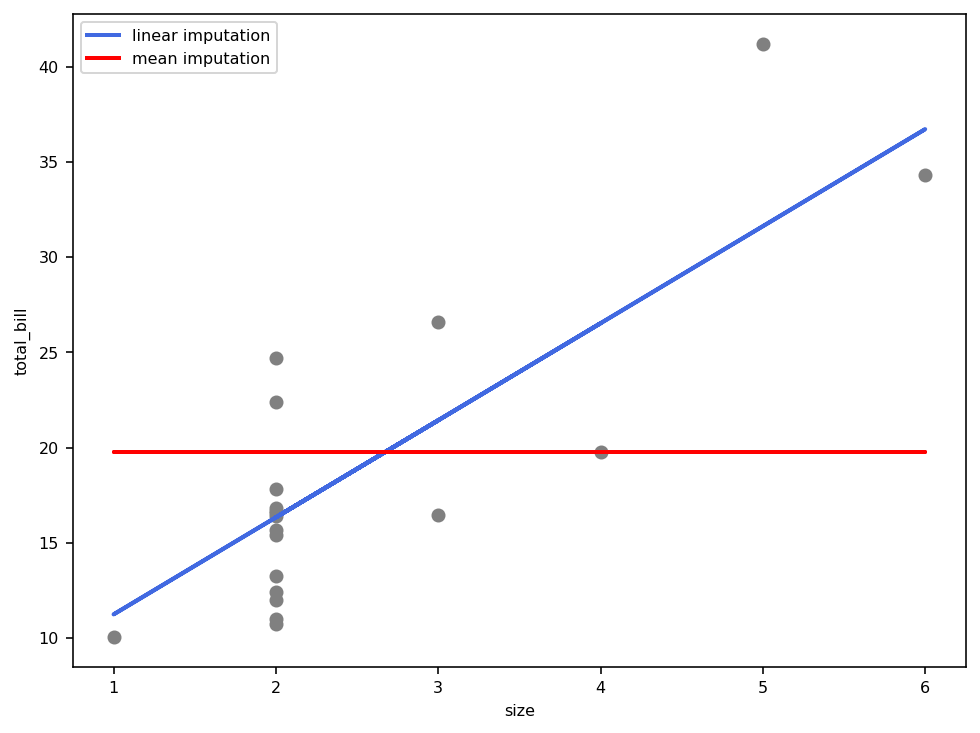

In [67]:
# Visualize the imputed total_bill values comparing to its true missing values
plt.scatter(size_misbill, df_train_full['total_bill'][missing_bill], color='gray')
plt.plot(size_misbill, bill_pred, color='royalblue', linewidth=2, label='linear imputation')
plt.plot(size_misbill, mean_total_bill*np.ones(size_misbill.shape), color='r', linewidth=2, label='mean imputation')

plt.xlabel("size")
plt.ylabel("total_bill")
plt.legend()
plt.show()

Como podemos ver, el valor de `total_bill` imputado por el regresor lineal no recupera exactamente el valor original, pero captura la tendencia general (y es mejor que la imputación por estadísticos como la media). Además, podríamos utilizar más variables en el modelo de regresión para obtener una mejor imputación.



## Imputación mediante un K-NN (K-nearest neighbours)

Además de la imputación basada en regresores lineales, también puede utilizarse la imputación basada en vecinos. De hecho, la imputación basada en el vecino más cercano (KNN) es un ejemplo de este tipo de imputación. Para una variable discreta, la imputación KNN utiliza el valor más frecuente entre los `K` vecinos más cercanos y, para una variable continua, utiliza la media o la moda.

Para utilizar el KNN para la imputación, primero se entrena un modelo KNN utilizando datos completos. Para datos continuos, comúnmente se utiliza como métrica de la distancia euclídea, mientras que para datos discretos se suele usar la [distancia de hamming](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

En el siguiente ejemplo usamos `total_bill` para imputar valores de `size` (al contrario que antes).

In [68]:
from sklearn.neighbors import KNeighborsRegressor

# For the sake of simplicity, we set K=10
knn = KNeighborsRegressor(n_neighbors=10, weights = 'distance')
knn.fit(df_train_dropna.loc[:,['total_bill']], df_train_dropna.loc[:, 'size'])

# Find the missing values in size
missing_size = df_train['size'].isnull()
# extract the tips of observations with total_bill missing
df_missing_size = pd.DataFrame(df_train[['total_bill']][missing_size])

# used trained K-NN to predict missing sizes
imputed_size = knn.predict(df_missing_size)

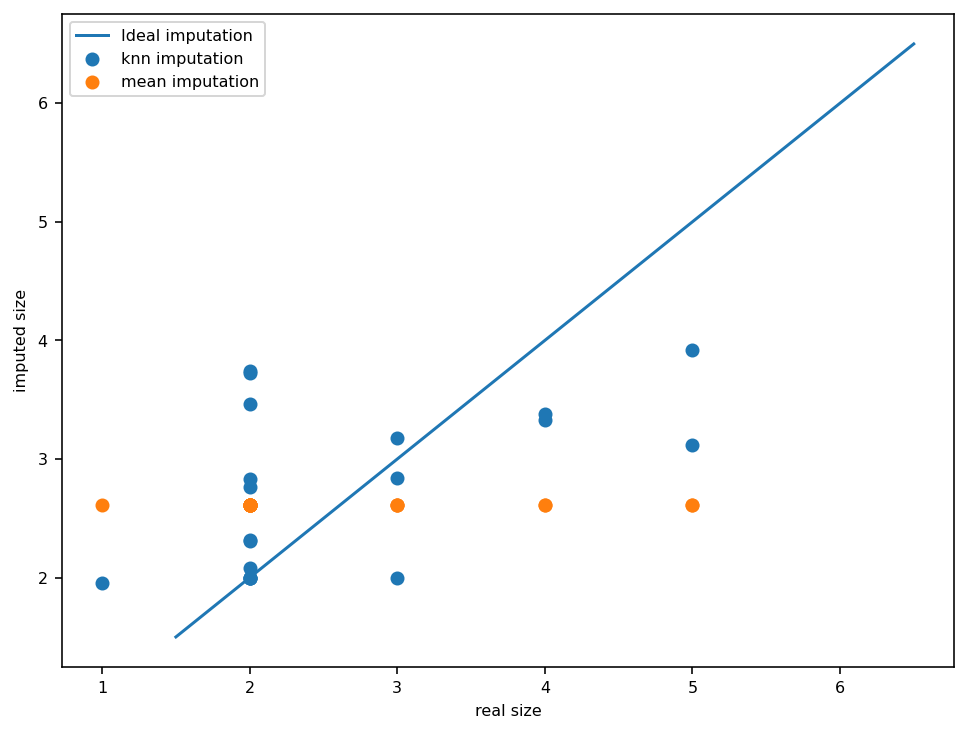

In [69]:
size_obs = df_train['size'].dropna(axis=0)
size_mis = df_train_full[['size']][missing_size]
size_knn_imp = pd.DataFrame(imputed_size)
size_mean_imp = df_mean[['size']][missing_size]

plt.figure()
plt.scatter(size_mis, size_knn_imp,label='knn imputation')
plt.scatter(size_mis, size_mean_imp,label='mean imputation')

plt.plot([1.5,6.5],[1.5,6.5],label='Ideal imputation')
plt.legend()
plt.xlabel('real size')
plt.ylabel('imputed size')
plt.show()

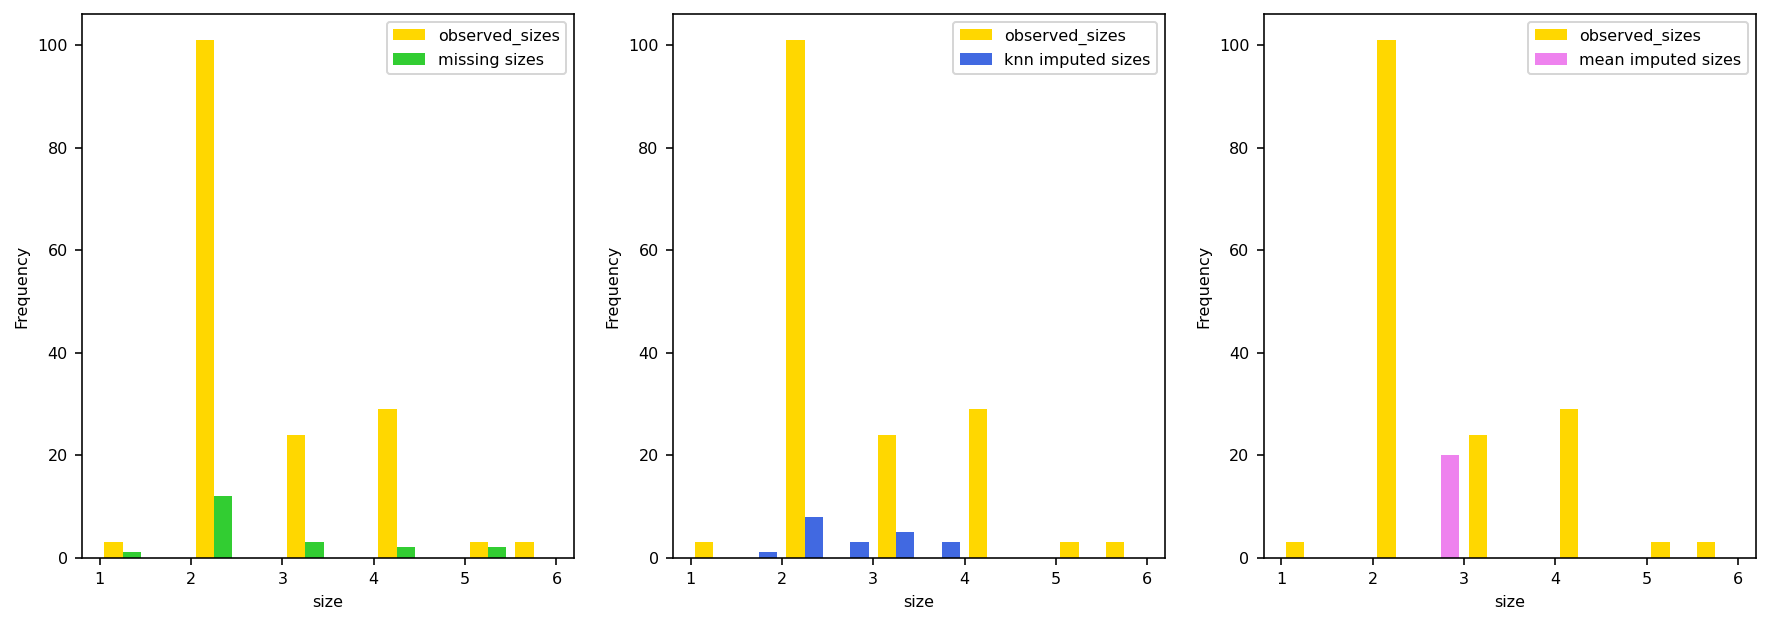

In [70]:
# Compare the imputed size distribution to its true missing values
legend_1 = ['observed_sizes', 'missing sizes']
legend_2 = ['observed_sizes', 'knn imputed sizes']
legend_3 = ['observed_sizes', 'mean imputed sizes']

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist([size_obs, np.squeeze(size_mis)], color=['gold', 'limegreen'])
plt.xlabel("size")
plt.ylabel("Frequency")
plt.legend(legend_1)

plt.subplot(1,3,2)
plt.hist([size_obs, np.squeeze(size_knn_imp)], color=['gold', 'royalblue'])
plt.xlabel("size")
plt.ylabel("Frequency")
plt.legend(legend_2)

plt.subplot(1,3,3)
plt.hist([size_obs,  np.squeeze(size_mean_imp)], color=['gold', 'violet'])
plt.xlabel("size")
plt.ylabel("Frequency")
plt.legend(legend_3)

plt.show()

En el gráfico anterior, comparamos los valores de `size` que faltan y los valores imputados utilizando tanto un imputador KNN como la imputación basada en la media. Como podemos ver, el imputador KNN da una imputación mucho mejor que los métodos de que estiman un valor único como la imputación de la media.

En general, el imputador KNN es simple, flexible (puede ser usado para cualquier tipo de datos), y fácil de interpretar. Sin embargo, si el conjunto de datos es grande, el uso de un imputador KNN podría ser lento.


Además, sklearn tiene una clase [`KNNImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer) que  permite imputar los valores perdidos utilizando el enfoque K-NN. Además, esta implementación incluye varias funcionalidades interesantes:
* Incluye una métrica de distancia euclídea que soporta valores perdidos, `nan_euclidean`. Por lo que no hace falta eliminar los datos que tienen valores perdidos para construir el modelo de imputación.
* Trabaja de golpe sobre todas las variables sobre las que queramos hacer imputación, no hay que construir un modelo por variable a imputar.
* Por defecto, cada característica perdida es imputada usando los valores de los  `k=n_neighbors` vecinos más cercanos que tienen un valor para la característica. 
* Si una muestra tiene más de una característica perdida, entonces los `k` vecinos para esa muestra pueden ser diferentes dependiendo de la característica particular que se imputa. 
* Cuando el número de vecinos disponibles es menor que `n_neighbors`, para esa característica se utiliza  el valor medio de esa variable durante la imputación. 
* Si una característica siempre falta en el entrenamiento, se elimina durante la transformación. 


La siguiente celda muestra cómo usar esta clase:

In [71]:
from sklearn.impute import KNNImputer
imp = KNNImputer(n_neighbors=10, weights="uniform")
x_train = df_train[['total_bill', 'size', 'time','sex','smoker']]
y_train = df_train['tip']
imp.fit(x_train)
imp_values=imp.transform(x_train)
pd.DataFrame(imp_values,columns=['total_bill', 'size', 'time','sex','smoker']).sample(n=20)


total_bill  size  time  sex  smoker
126      21.207   6.0   0.0  0.0     1.0
182      15.770   2.0   1.0  1.0     1.0
78       10.510   2.0   1.0  0.0     1.0
19       12.690   2.2   1.0  0.0     1.0
94       26.880   4.0   1.0  0.0     0.6
38       13.000   2.0   0.0  1.0     0.0
176      10.630   2.0   1.0  1.0     0.0
148      30.060   3.0   1.0  0.0     0.0
66       31.270   3.0   1.0  0.0     1.0
129      14.867   2.0   0.0  0.0     0.0
8        13.390   2.2   1.0  1.0     1.0
97       12.460   2.0   1.0  0.0     0.5
17       18.280   2.8   0.0  0.0     1.0
7        38.010   2.5   1.0  0.0     0.0
44       20.290   2.0   0.9  0.0     0.0
22       16.040   3.0   1.0  0.0     1.0
86        7.510   2.0   0.0  0.4     1.0
140      18.240   2.0   1.0  0.0     1.0
85        9.940   2.0   1.0  0.3     1.0
145      13.420   2.0   0.0  1.0     0.0

Obsérvese que en el código anterior es posible que queramos aprender el modelo de imputación con una partición de datos de entrenamiento y posteriormente predecir los valores (`transform`) sobre los datos de entrenamiento y test.

Todo esto se puede hacer fácilmente integrando la imputación en un pipeline...

In [72]:
from sklearn.impute import KNNImputer
param_grid = {
    'imp__n_neighbors' : range(1,20),
    'imp__weights':['uniform'],
    'kNN__n_neighbors': range(1,20),
    'kNN__weights':['uniform'],
}

pipe = Pipeline([('imp', KNNImputer()), ('scaler', StandardScaler()), ('kNN', KNeighborsRegressor())])
grid_knn = GridSearchCV(pipe, param_grid, cv=cv)
grid_knn.fit(x_train, y_train)
R2_train = grid_knn.score(x_train, y_train)
R2_test = grid_knn.score(x_test, y_test)
print("R^2 en el conjunto de entrenamiento: {0:.2f}".format(R2_train))
print("R^2 en el conjunto de test: {0:.2f}".format(R2_test))
print(grid_knn.best_params_)

R^2 en el conjunto de entrenamiento: 0.36
R^2 en el conjunto de test: 0.43
{'imp__n_neighbors': 4, 'imp__weights': 'uniform', 'kNN__n_neighbors': 13, 'kNN__weights': 'uniform'}


## Imputación Iterativa

Un enfoque más sofisticado consiste en utilizar la clase de sklearn [`IterativeImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer), que modela cada variable con valores perdidos como una función de las otras características, y utiliza esa estimación para la imputación. Lo hace de forma iterada: en cada paso, una columna se designa como salida `y` y las otras columnas se tratan como entradas `X`. Un regresor se ajusta en `X`, `y` para `y` conocido. Luego, el regresor se usa para predecir los valores perdidos de `y`. Esto se hace para cada característica de forma iterativa, y luego se repite para un conjunto de rondas de imputación dado por `max_iter`. Finalmente, el modelo devuelve los valores de la ronda de imputación final.



In [73]:
# This estimator is still experimental for now
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=5, random_state=0, estimator=KNeighborsRegressor(n_neighbors=10))
x_train = df_train[['total_bill', 'size', 'time','sex','smoker']]
y_train = df_train['tip']
imp.fit(x_train)
imp_values=imp.transform(x_train)
pd.DataFrame(imp_values,columns=['total_bill', 'size', 'time','sex','smoker']).sample(n = 20) 


total_bill  size  time  sex  smoker
108      32.400   4.0   1.0  0.0     1.0
9        10.330   2.0   1.0  1.0     1.0
8        13.390   2.0   1.0  1.0     1.0
1        28.150   4.0   1.0  0.0     0.0
180      12.600   2.0   1.0  0.0     0.0
141      22.670   2.0   1.0  0.0     0.0
103       7.250   2.0   1.0  0.0     0.0
25       22.230   2.0   1.0  0.0     1.0
139      14.498   2.0   1.0  1.0     0.0
129      15.762   2.0   0.0  0.0     0.0
28       13.130   2.0   1.0  0.0     1.0
34       15.980   2.0   0.0  0.0     1.0
5        25.280   3.4   1.0  1.0     0.0
158      25.290   4.0   1.0  0.0     1.0
20       20.760   2.0   1.0  0.0     1.0
31        9.550   2.0   1.0  0.0     1.0
87       24.060   3.0   1.0  0.3     1.0
16       20.920   3.0   1.0  1.0     1.0
140      18.240   2.0   1.0  0.0     1.0
89       14.000   2.0   1.0  0.3     1.0

In [74]:
from sklearn.impute import IterativeImputer
from warnings import filterwarnings
filterwarnings('ignore')
rango_vecinos = range(1,20,2)
list_iterative_imputer = [KNeighborsRegressor(n_neighbors=nn) for nn in rango_vecinos]
list_iterative_imputer.append(LinearRegression())
param_grid = {
    'imp__estimator':list_iterative_imputer,
    'kNN__n_neighbors': range(1,20,2),
    'kNN__weights':['uniform','distance'],
}

pipe = Pipeline([('imp', IterativeImputer(max_iter=20, tol=0.1, random_state=0)), 
                 ('scaler', StandardScaler()), 
                 ('kNN', KNeighborsRegressor())])
grid_knn = GridSearchCV(pipe, param_grid, cv=cv)
grid_knn.fit(x_train, y_train)
R2_train = grid_knn.score(x_train, y_train)
R2_test = grid_knn.score(x_test, y_test)
print("R^2 en el conjunto de entrenamiento: {0:.2f}".format(R2_train))
print("R^2 en el conjunto de test: {0:.2f}".format(R2_test))
print(grid_knn.best_params_)

R^2 en el conjunto de entrenamiento: 0.37
R^2 en el conjunto de test: 0.37
{'imp__estimator': KNeighborsRegressor(n_neighbors=15), 'kNN__n_neighbors': 15, 'kNN__weights': 'uniform'}


## Otros métodos de imputación

Hasta ahora, hemos hablado de algunos métodos comunes que pueden utilizarse para la imputación de valores perdidos. Según la naturaleza de los datos o el tipo de datos, algunos otros métodos de imputación pueden ser más apropiados. Por ejemplo:

* Para **datos longitudinales**, como el peso de los pacientes durante un período de revisiones médicas, podría tener sentido usar la última observación válida para llenar los NA. En los dataframes, esto puede hacerse usando el método de `ffill` en `.fillna`:
    `df_l = df.fillna(method='ffill')`

* Para los datos de **series temporales**, podría tener sentido utilizar la interpolación de los valores observados antes y después de un instante dado de tiempo para los valores que faltan. En los dataframes, pueden aplicarse diversos métodos de interpolación (por ejemplo, polinómicos, splines) utilizando `interpolate`.

    `df_interp = df.interpolate(method = 'linear', limit_direction = 'forward', axis=0)`



# 2. Detección de outliers

Los **outliers** son valores atípicos que se desvían de otras observaciones de los datos; en otras palabras, un valor atípico u outlier es una observación que está lejos del resto de las observaciones o del centro de masa de las observaciones. Los detectores de outliers, por lo tanto, intentan ajustar las regiones donde los datos de entrenamiento están más concentrados, ignorando las observaciones con un comportamiento diferente.

Los valores atípicos pueden ser causados por errores humanos, instrumentales o de procesamiento, por ejemplo, durante la adquisición, registro o procesamiento de los datos, o por errores de medición o experimentales.

En el aprendizaje automático es importante identificar y eliminar los valores atípicos de los datos cuando se entrenan los algoritmos de modelización predictiva.
Los valores atípicos pueden sesgar las medidas estadísticas y las distribuciones de datos, proporcionando una representación engañosa de los datos y de las relaciones subyacentes. La eliminación de los valores atípicos de los datos de entrenamiento antes del modelado puede dar lugar a un mejor ajuste de los datos y, a su vez, a predicciones más eficientes.

Como la detección de valores atípicos consiste en detectar las observaciones que están lejos del resto de las observaciones, la mayoría de los métodos se basan en la estimación de la densidad de probabilidad de los datos, por ejemplo, utilizando el Modelo de Mezcla Gaussianas (GMM). Además, Sklearn incluye otros tres enfoques específicos:
* Isolation Forest
* Minimum Covariance Determinant
* Local Outlier Factor


Para analizar el funcionamiento de estos modelos, consideremos un conjunto de datos sintético (bidimensional) y luego consideraremos que nos llega un conjunto de muestras nuevas entre las que hay datos atípicos a detectar. Sobre este ejmplo, veremos método por método su funcionamiento y analizaremos su capacidad para detectar valores atípicos.

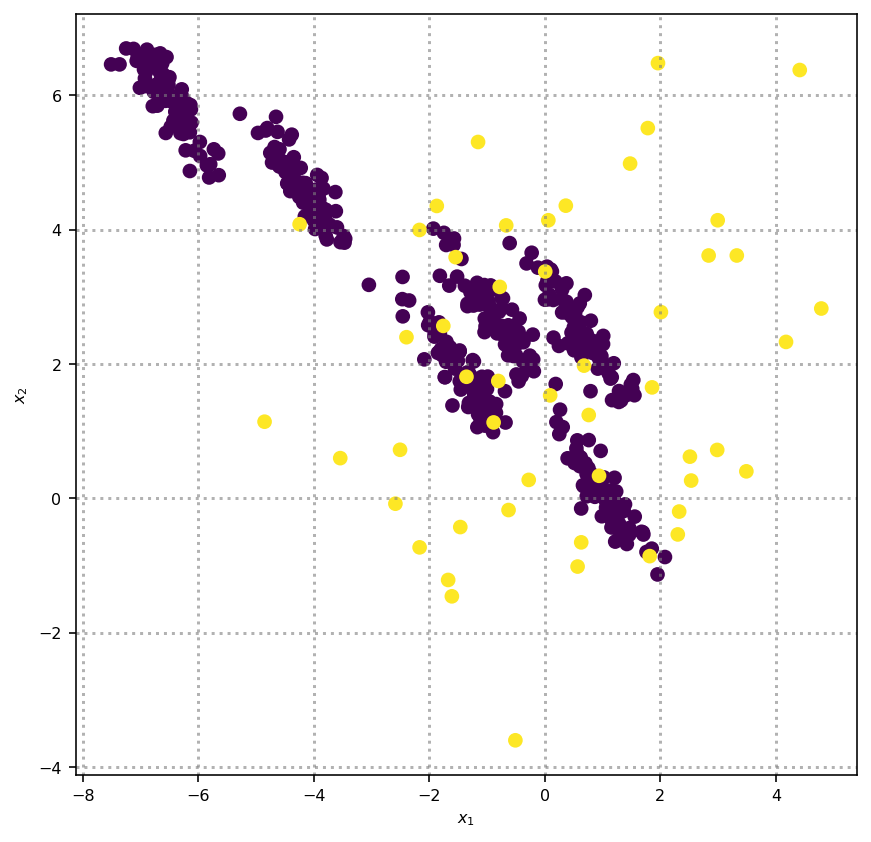

In [76]:
from sklearn.datasets import make_blobs
# Generate synthetic data
X, y_true = make_blobs(n_samples=450, centers=6,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

# Add new data (outliers??)
center_outliers = np.array([0,2]).reshape([1,-1])
X_outlier,_ = make_blobs(n_samples=50,centers=center_outliers, cluster_std=2,random_state=123)
X_out_example = np.vstack([X_stretched,X_outlier])
y_outlier = np.zeros([X_out_example.shape[0],])
y_outlier[-50:] = 1 # Vector binario que vale 1 en los outliers introducidos artificialmente

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


Observese que al generar los nuevos datos (amarillo), hemos introducido los datos en posiciones aleatorias, por lo que algunos de ellos siguen la misma distribución que nuestros datos de entrenamiento, y lógicamente no serán atípicos, mientras que otros no tienen nada que ver y esperaremos que sean detectados como atípicos.

## Isolation Forest

El [`IsolationForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest) *aísla* las observaciones seleccionando de manera iterativa y aleatoriamente una característica y luego seleccionando al azar un valor umbral (o splitting) elegido entre los valores máximo y mínimo de la variable seleccionada.

Como la partición recursiva puede representarse mediante una estructura de árbol, el número de particiones necesarias para aislar una muestra equivale a la longitud del trayecto desde el nodo raíz hasta el nodo terminal. Los datos más típicos necesitarán más iteraciones (splittings) o longitudes de trayecto más largas para ser aislados, por lo que esta longitud del camino, promediada sobre un bosque de esos árboles aleatorios, es una medida de la normalidad y nuestra función de decisión o detección de outliers. Nótese que la partición aleatoria produce caminos notablemente más cortos para las anomalías. Por lo tanto, cuando un bosque de árboles aleatorios produce en media longitudes de camino más cortas para determinadas muestras, es muy probable que sean anomalías.

Quizás el hiperparámetro más importante del modelo es el argumento  `contamination`, que se utiliza para ayudar a estimar el número de valores atípicos en el conjunto de datos. Este es un valor entre 0,0 y 0,5 y por defecto se establece en 0,1.

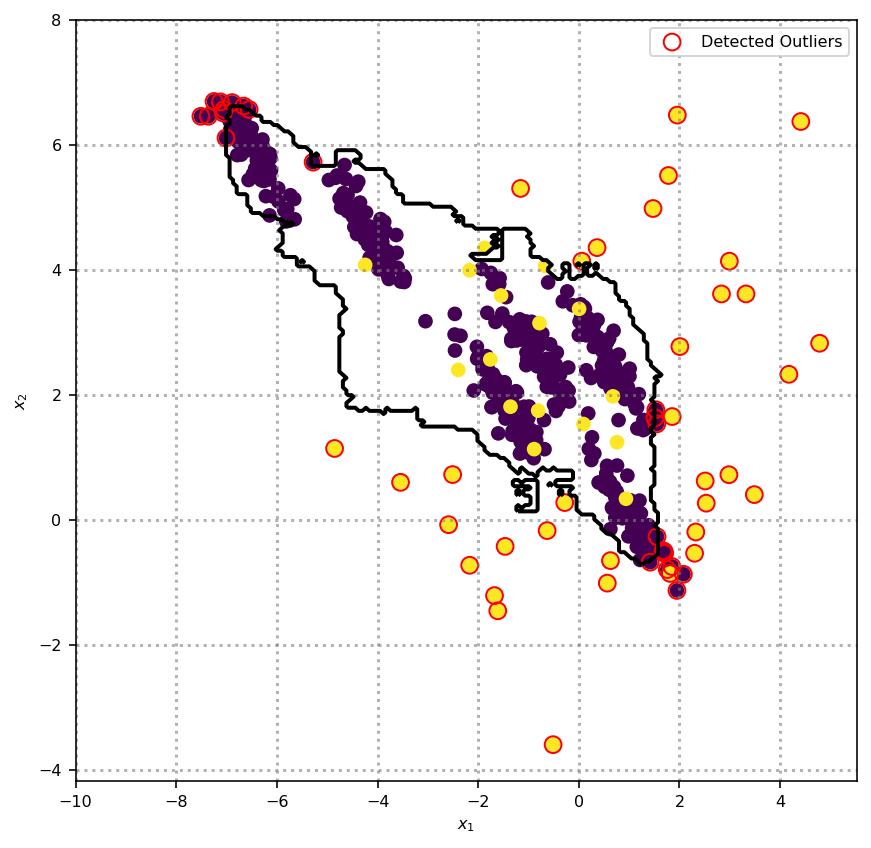

In [94]:
from sklearn.ensemble import IsolationForest
# identify outliers in the training dataset
iForest = IsolationForest(contamination=0.05,random_state=1234)  # Check 0.01, 0.05, 0.1
#iForest.fit(X_stretched)
iForest.fit(X_stretched)
youtliers = iForest.predict(X_out_example)

idx_outliers =  np.where(youtliers == -1)[0]

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.scatter(X_out_example[idx_outliers, 0], X_out_example[idx_outliers, 1], marker="o",facecolor="none",edgecolor="r",s=70, label='Detected Outliers')
plt.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)

# Plot boundary
# We created a grid
intervals = 200
x = np.linspace(-10, 4, intervals)
y = np.linspace(-2, 8, intervals)
X,Y = np.meshgrid(x,y)
xys = np.vstack([X.ravel(), Y.ravel()]).T
ygrid = iForest.predict(xys)
ygrid = ygrid.reshape([intervals,intervals])

ax.contour(X, Y, ygrid, levels=[0], linewidths=2, colors='black') 
plt.show()

## Ajuste por mínima covarianza o envolvente elíptica

Si las variables de entrada tienen una distribución gaussiana, entonces se pueden utilizar métodos estadísticos simples para detectar los valores atípicos. Por ejemplo, si el conjunto de datos tiene dos variables de entrada y ambas son gaussianas, entonces el espacio de datos de entrada forma un gaussiana multidimensional y el hecho de conocer esta distribución puede utilizarse para identificar valores alejados de la misma. Este enfoque puede generalizarse definiendo una hiperesfera (elipsoide) que abarque los datos normales, y los datos que queden fuera de esta forma se considerarán atípicos. 

La clase [EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) de sklearn implementa esta aproximación y también tiene el parámetro `contaminación` que define la proporción esperada de valores atípicos. 


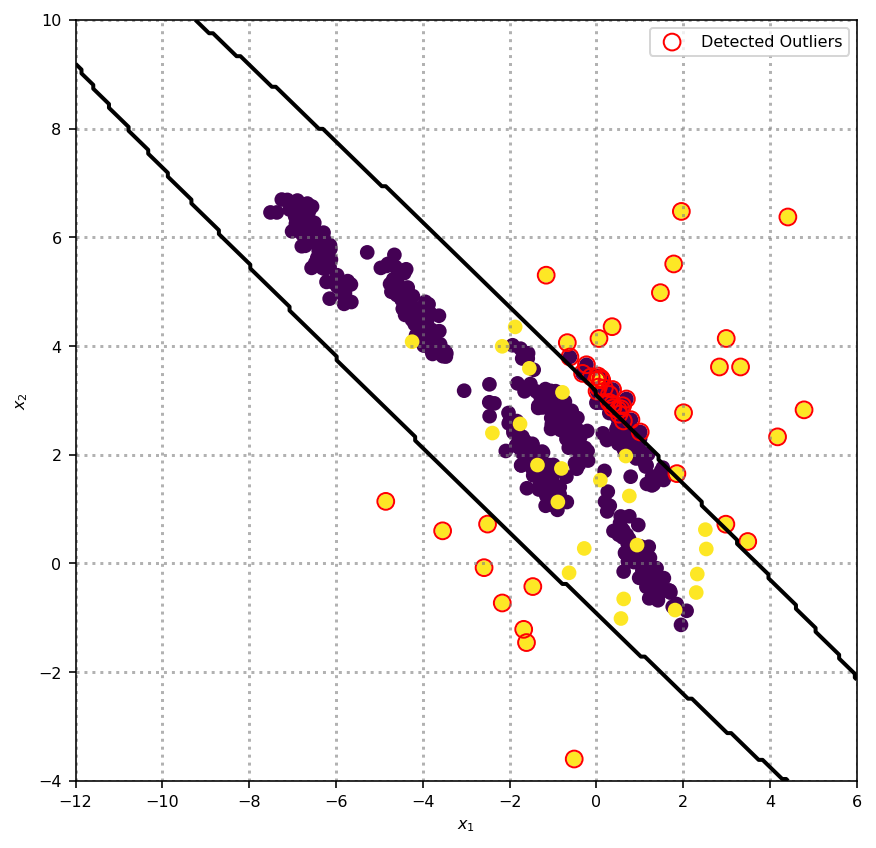

In [104]:
from sklearn.covariance import EllipticEnvelope

# identify outliers in the training dataset
ee = EllipticEnvelope(contamination=0.05,random_state=1234) # Check 0.01, 0.05, 0.1
ee.fit(X_stretched)
youtliers = ee.predict(X_out_example)

idx_outliers =  np.where(youtliers == -1)[0]

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.scatter(X_out_example[idx_outliers, 0], X_out_example[idx_outliers, 1], marker="o",facecolor="none",edgecolor="r",s=70, label='Detected Outliers')
plt.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


# Plot boundary
# We created a grid
intervals = 200
x = np.linspace(-12, 6, intervals)
y = np.linspace(-4, 10, intervals)
X,Y = np.meshgrid(x,y)
xys = np.vstack([X.ravel(), Y.ravel()]).T
ygrid = ee.predict(xys)
ygrid = ygrid.reshape([intervals,intervals])

ax.contour(X, Y, ygrid, levels=[0], linewidths=2, colors='black') 
plt.show()

## Local Outlier Factor

El [local outlier factor (LOF)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) mide la desviación local de una muestra dada con respecto a la de sus vecinos. Es local en el sentido de que la  anomalía depende de cuán aislado está la muestra con respecto al vecindario circundante. En concreto, la localidad viene dada por un algoritmo KNN, cuya distancia se utiliza para estimar la densidad local. Comparando la densidad local de una muestra con las densidades locales de sus vecinos, se pueden identificar muestras que tienen una densidad sustancialmente menor que sus vecinos. 

Esto puede funcionar bien para espacios de características con baja dimensionalidad (pocas características) y suele volverse menos fiable a medida que se aumenta el número de características, lo que se conoce como la maldición de la dimensionalidad (*curse of dimensionality*).

Aquí nos encontramos dos parámetros a ajustar, el nivel de `contaminación` y el número de vecinos (establecido en 20 por defecto).

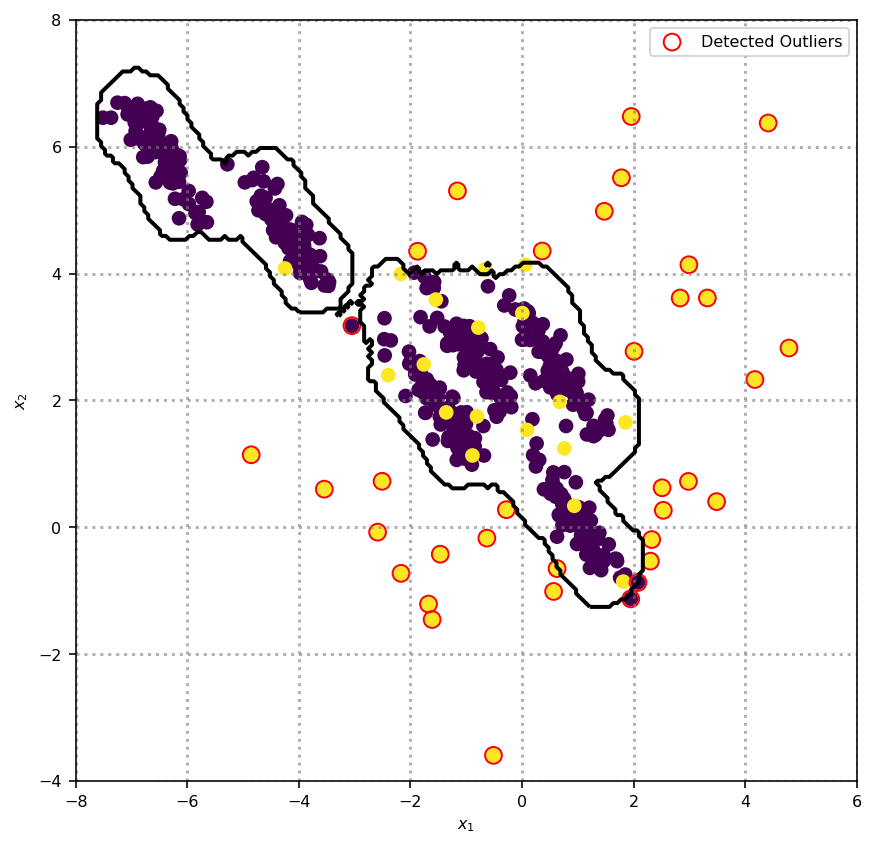

In [109]:
from sklearn.neighbors import LocalOutlierFactor

# identify outliers in the training dataset
lof = LocalOutlierFactor(contamination=0.01, novelty=True) # Check 0.01, 0.05, 0.1
lof.fit(X_stretched)
youtliers = lof.predict(X_out_example)

idx_outliers =  np.where(youtliers == -1)[0]

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.scatter(X_out_example[idx_outliers, 0], X_out_example[idx_outliers, 1], marker="o",facecolor="none",edgecolor="r",s=70, label='Detected Outliers')
plt.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)

# Plot boundary
# We created a grid
intervals = 200
x = np.linspace(-8, 6, intervals)
y = np.linspace(-4, 8, intervals)
X,Y = np.meshgrid(x,y)
xys = np.vstack([X.ravel(), Y.ravel()]).T
ygrid = lof.predict(xys)
ygrid = ygrid.reshape([intervals,intervals])

ax.contour(X, Y, ygrid, levels=[0], linewidths=2, colors='black') 
plt.show()


## Gaussian Mixture Models (GMM)

Los [modelos de mezcla](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch20.pdf) son un tipo de modelos probabilísticos que permiten aproximar la densidad de probabilidad de los datos y, por tanto, utilizar esta información para detectar valores atípicos de la distribución.
Un modelo de mezcla de gaussianas (Gaussian Mixture Model, GMM) ajustará una función de densidad de probabilidad parametrizada a nuestros datos de la siguiente manera:

\begin{align}
p(\mathbf{x}) = \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)
\end{align}

donde

- $\pi_k$ es la probabilidad de que los datos provengan de la $k$-ésima gaussiana.

- Asume que todos los datos asignados a la gaussiana de $k$-th se distribuyen de acuerdo a una media gaussiana de $\mathbf{\mu}_k$ y una matriz de covarianza de $\boldsymbol{\Sigma}_k$. 

- $(\pi_1,\ldots,\pi_K)$, $(\mathbf \mu_1,\ldots,\mathbf \mu_K)$, $(\boldsymbol{\Sigma}_1,\ldots,\boldsymbol{\Sigma}_K)$  son los parámetros del modelo.

Todos estos parámetros del modelo se eligen para maximizar la **probabilidad de que el modelo haya generado nuestras observaciones (verosimilitud)**:


$$ \max_{(\pi_1,\ldots,\pi_K),(\mathbf{\mu}_1,\ldots,\mathbf{\mu}_K), (\boldsymbol{\Sigma}_1,\ldots,\boldsymbol{\Sigma}_K)}  ~~\sum_{n=1}^{N} \log  p(\mathbf{x}_n) $$

Este problema de encontrar valores para estos parámetros de la densidad de probabilidad se resuelve numéricamente mediante un algoritmo iterativo conocido como **EM** (Expectation-Maximization).

Aunque este enfoque no está incluido en sklearn como técnica de detección de novedad, podemos utilizar su implementación [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) para el modelado y agrupación de datos, tal como se utiliza habitualmente. 

Nótese que este enfoque puede considerarse una extensión del enfoque de la Elliptic Envelope, en el que en lugar de considerar un sola gaussiana para modelar nuestros datos, utilizamos una mezcla de gaussianas para poder modelar distribuciones de datos más complejas.


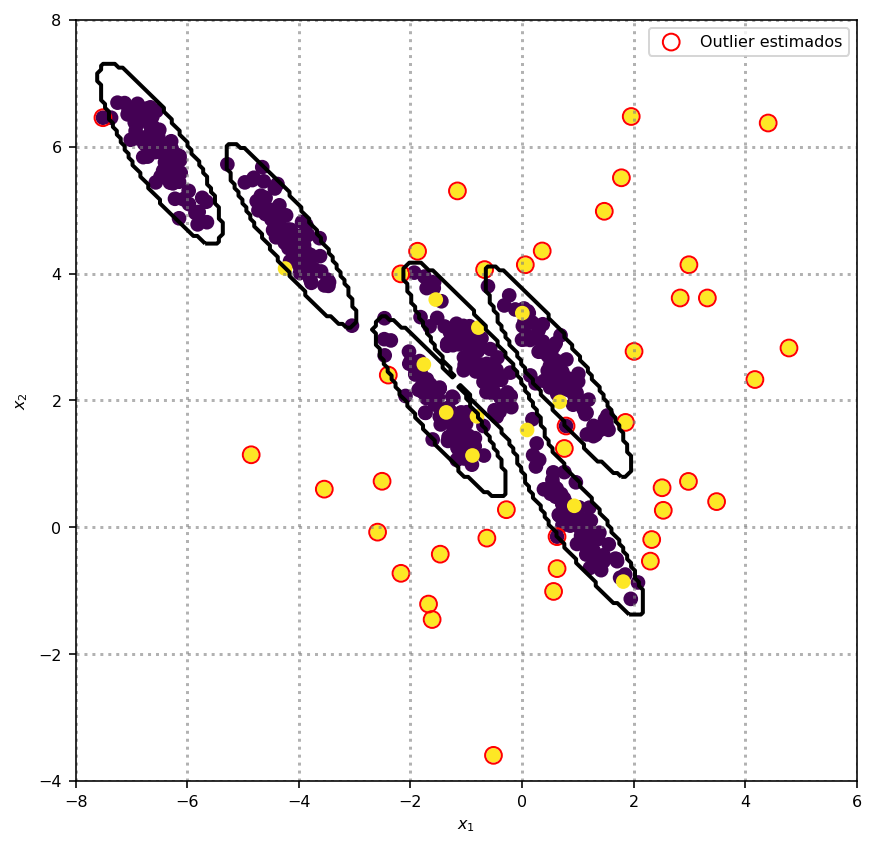

In [124]:
from sklearn.mixture import GaussianMixture

# As we know the dataset, we set K=4 (otherwise this parameters has to be selected)
# Check K= 4, K=6, K=8
K = 6
gmm = GaussianMixture(n_components=K,covariance_type='full',n_init=200) 

gmm.fit(X_stretched) 
log_probs_train = gmm.score_samples(X_stretched)
frac = 0.01 # We set the number of contaminated data  (frac=0.1, 0.05, 0.01)
th_novelty = np.sort(log_probs_train)[:int(np.round(X_stretched.shape[0]*frac))][-1]

log_probs = gmm.score_samples(X_out_example)

youtliers = np.where(log_probs < th_novelty, -1, 1)
idx_outliers =  np.where(youtliers == -1)[0]

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.scatter(X_out_example[idx_outliers, 0], X_out_example[idx_outliers, 1], marker="o",facecolor="none",edgecolor="r",s=70, label='Outlier estimados')
plt.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


# Plot boundary
# We created a grid
intervals = 200
x = np.linspace(-8, 6, intervals)
y = np.linspace(-4, 8, intervals)
X,Y = np.meshgrid(x,y)
xys = np.vstack([X.ravel(), Y.ravel()]).T
xys_log_probs = gmm.score_samples(xys)
ygrid = np.where(xys_log_probs < th_novelty, -1, 1)
ygrid = ygrid.reshape([intervals,intervals])

ax.contour(X, Y, ygrid, levels=[0], linewidths=2, colors='black') 
plt.show()


Para este modelo podemos trazar las curvas de contorno, es decir, las curvas sobre el espacio $(x_1,x_2)$ con igual probabilidad $p(\mathbf{x})$. También la propia $p(\mathbf{x})$ en una figura 3D. De esta manera, podemos analizar la distribución de los datos aprendidos.

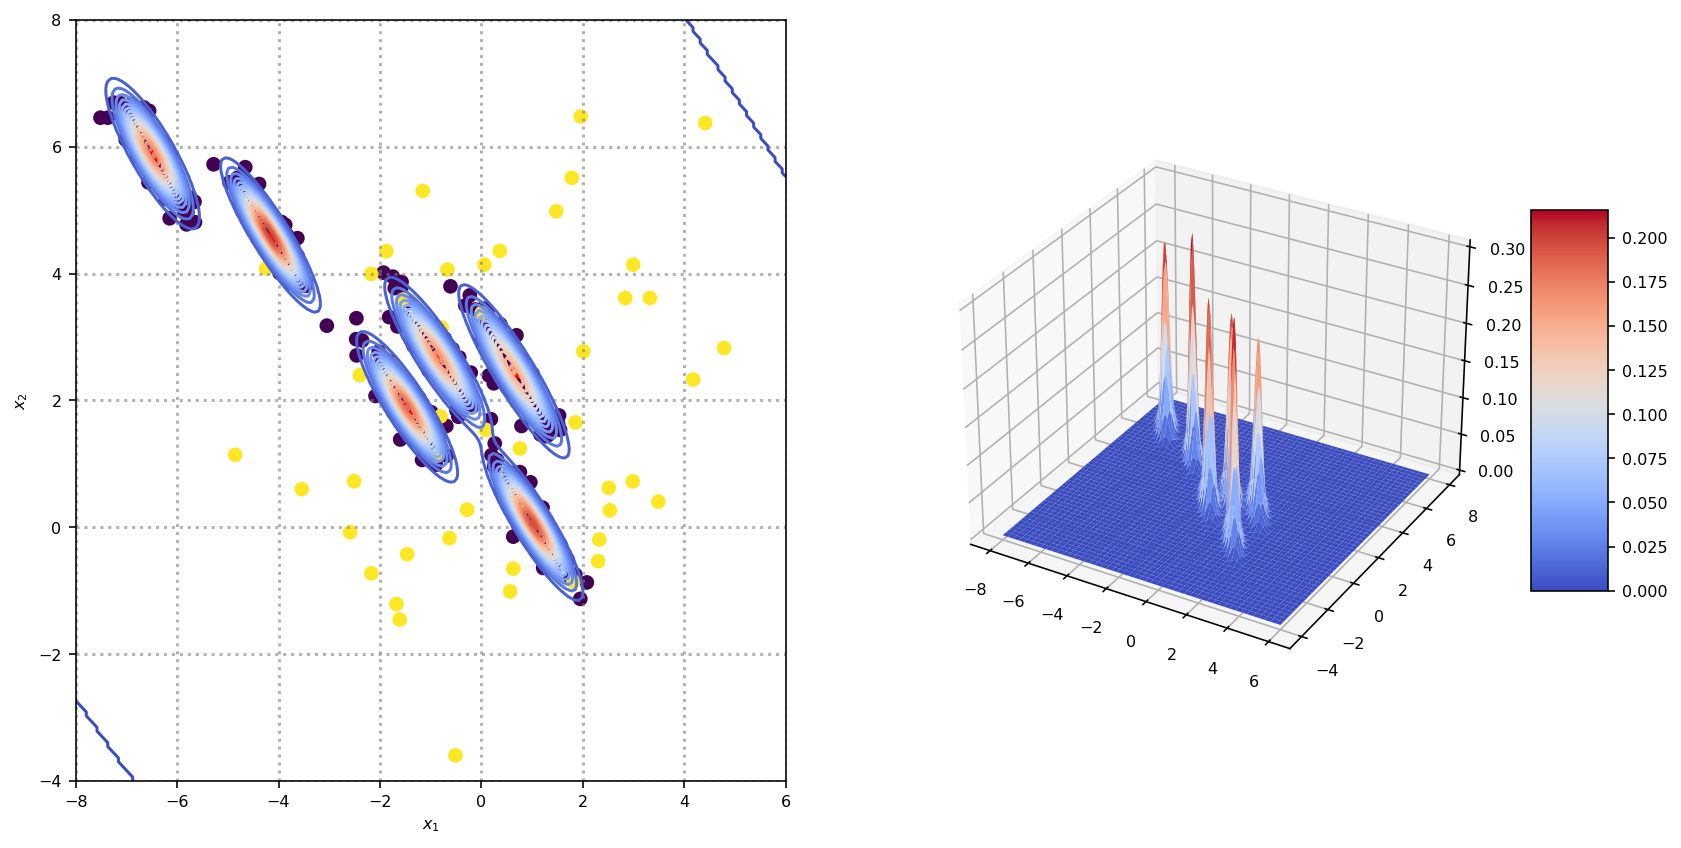

In [125]:
from scipy.stats import multivariate_normal as mvn #Multivariate normal distribution
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Lets plot the pdf contour plot
intervals = 200

# We created a grid
x = np.linspace(-8, 6, intervals)
y = np.linspace(-4, 8, intervals)
X,Y = np.meshgrid(x,y)

xys = np.vstack([X.ravel(), Y.ravel()]).T

# We evaluate p(x) for each point of the grid
Zgmm = np.zeros(len(xys))
for k in range(K):
    Zgmm += gmm.weights_[k]*mvn(gmm.means_[k,:], gmm.covariances_[k]).pdf(xys)
    
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 2, 1)

Zgmm = Zgmm.reshape([intervals,intervals])
ax.contour(X, Y, Zgmm, 20, cmap=cm.coolwarm) 
ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=40, marker='^', facecolor='red')

ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, Zgmm, cmap=cm.coolwarm)
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


# Selección de características

El objetivo de la selección de características (Feature Selection, FS) es encontrar el subconjunto de aquellas características que son relevantes (informativas) y necesarias para resolver la tarea objetivo. Su aplicación en un pipeline de ML tiene varias ventajas:
* Desde el punto de vista del entrenamiento, puede proporcionar reducciones de coste computacional y mejoras de rendimiento.
* También proporciona una ganancia de interpretación sobre el problema. 
* Además, en algunas aplicaciones, simplifica el proceso de obtención de características ya que evita la extracción de características innecesarias.

Las técnicas de FS se dividen en tres grupos:

1. **Métodos de filtrado**: El proceso de FS es independiente de la posterior etapa de clasificación/regresión. Este tipo de métodos lo usamos para obtener un ranking de variables.
2. **Wrappers**: evalúan el modelo/prestaciones del predictor final para seleccionar el mejor subconjunto de características. Por ejemplo, un enfoque de eliminación recursiva de variables evaluando la característica a eliminar con el error de CV del predictor sería un tipo de wrapper.
3. **Embedded**: el proceso de FS se integra en el entrenamiento del clasificador/regresor final. Este es el caso de los modelos ML con regularización L1.



<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/FeatureSelection/FS_1es.png" width="60%"> 

A lo largo de este notebook, vamos a introducir estas tres estrategias de FS; para ello, trabajaremos con un problema de predicción de precios de coches. Así que empecemos cargando y preparando los datos.


## Carga de datos

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.read_csv("http://www.tsc.uc3m.es/~vanessa/data_notebooks/autos/autos.csv")

df.head()

symboling         make fuel_type aspiration  num_of_doors   body_style  \
0          3  alfa-romero       gas        std             2  convertible   
1          3  alfa-romero       gas        std             2  convertible   
2          1  alfa-romero       gas        std             2    hatchback   
3          2         audi       gas        std             4        sedan   
4          2         audi       gas        std             4        sedan   

  drive_wheels engine_location  wheel_base  length  ...  engine_size  \
0          rwd           front        88.6   168.8  ...          130   
1          rwd           front        88.6   168.8  ...          130   
2          rwd           front        94.5   171.2  ...          152   
3          fwd           front        99.8   176.6  ...          109   
4          4wd           front        99.4   176.6  ...          136   

   fuel_system  bore stroke  compression_ratio  horsepower peak_rpm  city_mpg  \
0         mpfi  3.47   2.68                  9         111     5000        21   
1         mpfi  3.47   2.68                  9         111     5000        21   
2         mpfi  2.68   3.47                  9         154     5000        19   
3         mpfi  3.19   3.40                 10         102     5500        24   
4         mpfi  3.19   3.40                  8         115     5500        18   

   highway_mpg  price  
0           27  13495  
1           27  16500  
2           26  16500  
3           30  13950  
4           22  17450  

[5 rows x 25 columns]

In [127]:
X = df.copy()
y = X.pop("price")

In [128]:
v_cat = [element for element in X.dtypes[(X.dtypes=='O')].index.values]
no_v_cat = [element for element in X.dtypes[(X.dtypes!='O')].index.values]
print(v_cat)

['make', 'fuel_type', 'aspiration', 'body_style', 'drive_wheels', 'engine_location', 'engine_type', 'fuel_system']


In [129]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(X[v_cat])

Xcat = enc.transform(X[v_cat]).toarray()

Xcat = pd.DataFrame(Xcat, columns=enc.get_feature_names(v_cat)).astype('int64')

X = pd.concat([X[no_v_cat], Xcat], axis=1) 
X.head()

symboling  num_of_doors  wheel_base  length  width  height  curb_weight  \
0          3             2        88.6   168.8   64.1    48.8         2548   
1          3             2        88.6   168.8   64.1    48.8         2548   
2          1             2        94.5   171.2   65.5    52.4         2823   
3          2             4        99.8   176.6   66.2    54.3         2337   
4          2             4        99.4   176.6   66.4    54.3         2824   

   num_of_cylinders  engine_size  bore  ...  engine_type_ohc  \
0                 4          130  3.47  ...                0   
1                 4          130  3.47  ...                0   
2                 6          152  2.68  ...                0   
3                 4          109  3.19  ...                1   
4                 5          136  3.19  ...                1   

   engine_type_ohcf  engine_type_ohcv  fuel_system_1bbl  fuel_system_2bbl  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 1                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   fuel_system_idi  fuel_system_mfi  fuel_system_mpfi  fuel_system_spdi  \
0                0                0                 1                 0   
1                0                0                 1                 0   
2                0                0                 1                 0   
3                0                0                 1                 0   
4                0                0                 1                 0   

   fuel_system_spfi  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 63 columns]

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# split into a training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.4, random_state=25)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## 1. Métodos de filtrado

Los métodos de filtrado se caracterizan por ser independientes de la etapa de aprendizaje subsiguiente, por lo que utilizan un criterio de relevancia para medir la capacidad de predicción de cada característica y seleccionan u ordenan las características de entrada de acuerdo con este criterio.

Como **criterio de relevancia** podemos encontrar:
* Varianza (sin supervisión)
* Coeficiente de correlación (regresión). Este criterio de relevancia se encuentra implementado en el método [f_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) de sklearn.
* Test estadísticos: t-test (binario), F-test (multiclase), chi-square test (variables categóricas). Estos tests consisten en evaluar si los datos de las diferentes clases han sido generados por diferentes distribuciones o no. Estos test, los podemos encontrar implementados en sklearn en estos métodos:
  * [f_classif()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html): método para obtener el F-score entre cada característica de entrada y la tarea de clasificación a resolver.   En particular, este test se reduce a un t-test  cuando trabajamos con problemas binarios.
  * [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2): función para obtener los chi2-scores. Su funcionamiento es similar al del F-score, pero diseñado específicamente para características de entrada de tipo categórico.

* Información mutua. A continuación veremos este criterio en detalle y explicaremos las funciones que hay disponibles para implementarlo.
* Índice de Gini (utilizado por los árboles de decisión y random forests)

A continuación, veamos cómo usar algunos de estos criterios usando las funcionalidades que sklearn nos proporciona.

### Ranking de las variables con Información Mutua 
La Mutua de Información (Mutual information, MI) es capaz de medir cualquier tipo de relaciones entre dos variables aleatorias, a diferencia de la correlación que sólo detecta relaciones lineales. Formalmente, si tenemos dos v.a. $X$ e $Y$, la información mutua viene dada por:

$$ \mbox{MI} (X, Y) = \int \int p_{X,Y}(x,y) \log{\frac{p_{X,Y}(x,y)}{p_{X}(x)p_{Y}(y)}} $$

donde $p_{X,Y}(x,y)$ es la distribución conjunta entre $X$ y $Y$ y $p_{X}(x)$ y $p_{Y}(y)$ son sus distribuciones marginales. 

La menor información mutua posible entre cantidades es 0, que ocurre cuando $X$ y $Y$ son independientes. A la inversa, en teoría no existe un límite superior para la MI, pero en la práctica, los valores superiores a 2 son poco comunes. La información mutua es una cantidad logarítmica, por lo que aumenta muy lentamente.

**¿Qué información me da la MI?** 

La MI describe las relaciones en términos de incertidumbre. La MI entre dos cantidades es una medida del grado en que el conocimiento de una cantidad reduce la incertidumbre sobre la otra. Si conocieras el valor de una característica, ¿cuánto más seguro estarías sobre el objetivo?

Analicemos esta figura donde se muestra el precio de venta (`price`) de nuestros coches en función de su marca (`make`):



 

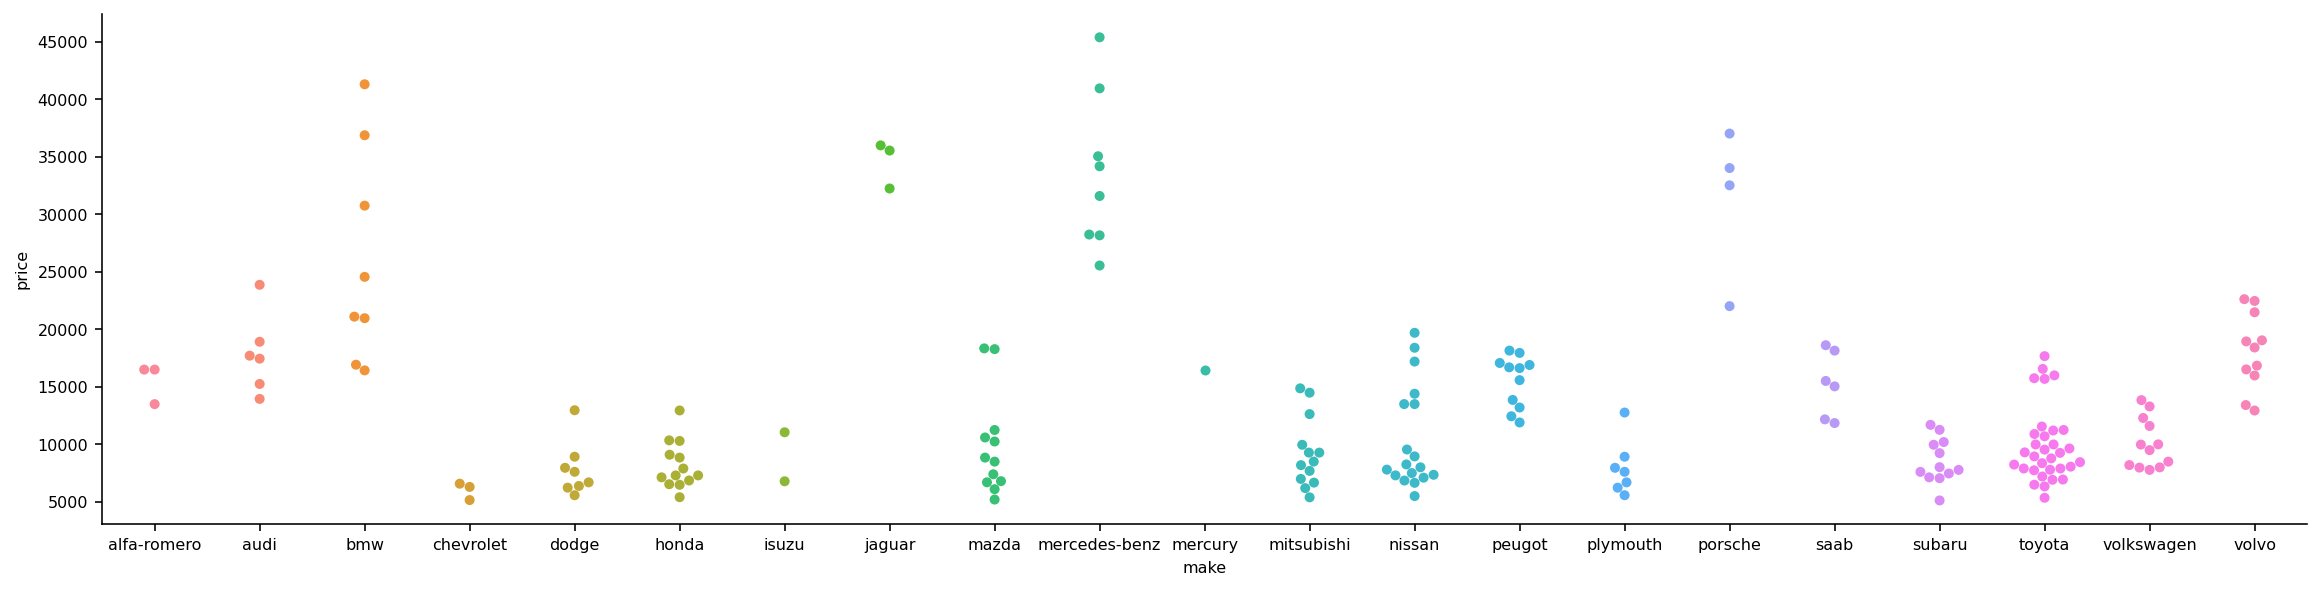

In [131]:
sns.catplot(data=df, kind="swarm", x="make", y="price", hue="make", height=4, aspect=4)

Como podemos ver el hecho de conocer el modelo del coche debería dar más seguridad sobre el valor de `Price`: cada categoría de `make` tiende a concentrar el precio dentro de un determinado rango. La información mutua que tiene `make` con `Price` es la reducción media de la incertidumbre en el precio de venta para cada uno de los valores de `make`. Dado que, por ejemplo, `alfa-romero` ocurre con menos frecuencia que `toyota`, `alfa-romero` tiene menos peso en el valor de MI.

Además, como hemos dicho, la MI es capaz de medir cualquier tipo de relación entre $X$ e $Y$, además de medir el grado de relación. Para ver esto, la siguiente figura muestra diferentes tipos de relaciones y los valores de MI asociados

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/FeatureSelection/MI2.png" width="100%"> 

La figura de la izquierda muestra diferentes variables (con diferentes colores) y vemos que las según la dependecia de la variable de entrada con la de salida es más estrecha (se reduce la incertidumbre), el valor de MI es mayor.

Por otro lado, la figura de la derecha  muestra cómo la MI puede capturar cualquier tipo de relación (no sólo lineal, como la correlación). 


**Calculo e implementación del valor de MI**

Como hemos indicado el valor de MI viene dado por esta expresión:


$$ MI (X, Y) = \int \int p_{X,Y}(x,y) \log{\frac{p_{X,Y}(x,y)}{p_{X}(x)p_{Y}(y)}} $$

El principal problema para obtener el valor de MI se basa en conocer estas distribuciones de probabilidad (normalmente desconocidas); así, la mayoría de las implementaciones utilizan estimadores de MI basados en histogramas de datos, enfoques de ventanas de Parzen o estimaciones de densidad basadas en K-NN. En particular, la implementación de MI de sklearn utiliza una estimación basada en K-NN. 

De hecho, scikit-learn tiene dos métricas de información mutua en su módulo `feature_selection`: una para variables objetivo reales ([mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html)) y otra para categóricas ([mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)). 


Nuestro objetivo, el precio, es de valor real, por lo que usaremos [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html)). Para usar esta función hay que tener en cuenta dos aspectos:
* Esta función tiene un parámetro (`k`:número de vecinos) que debería ajustarse mediante validación cruzada; sin embargo, para reducir el tiempo de cálculo en este ejemplo, usaremos su valor por defecto.
* Hay que especificarle a la función que variables son continuas y cuales discretas. Aquí utilizamos el término "discretas" en lugar de "categóricas", porque nos referimos a variables categóricas (que resultan ser discretas tras codificarse por ejemplo con un one-hot-encoding) y variables discretas como tales. Por ejemplo, las intensidades de los píxeles de una imagen son características discretas (pero no categóricas). La implementación de esta función obtendrá mejores resultados si le indicamos específicamente estas variables, ya que tratar una variable continua como discreta y viceversa suele dar resultados incorrectos, así que debemos estar atentos a ello.

Las siguientes celdas calculan las puntuaciones del MI para nuestras características y analiza los resultados


In [132]:
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

discrete_features

symboling           False
num_of_doors        False
wheel_base          False
length              False
width               False
                    ...  
fuel_system_idi     False
fuel_system_mfi     False
fuel_system_mpfi    False
fuel_system_spdi    False
fuel_system_spfi    False
Length: 63, dtype: bool

In [133]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    ind_rel_feat = np.argsort(mi_scores)[::-1]
    return ind_rel_feat, mi_scores


ind_rel_feat, mi_scores = make_mi_scores(X_train, Y_train, discrete_features)
mi_scores = pd.Series(mi_scores[ind_rel_feat], index =X.columns[ind_rel_feat]) 
mi_scores

highway_mpg         0.895842
curb_weight         0.860425
engine_size         0.850560
city_mpg            0.827290
horsepower          0.795796
                      ...   
engine_type_ohcf    0.000000
engine_type_ohcv    0.000000
make_mercury        0.000000
make_saab           0.000000
num_of_doors        0.000000
Length: 63, dtype: float64

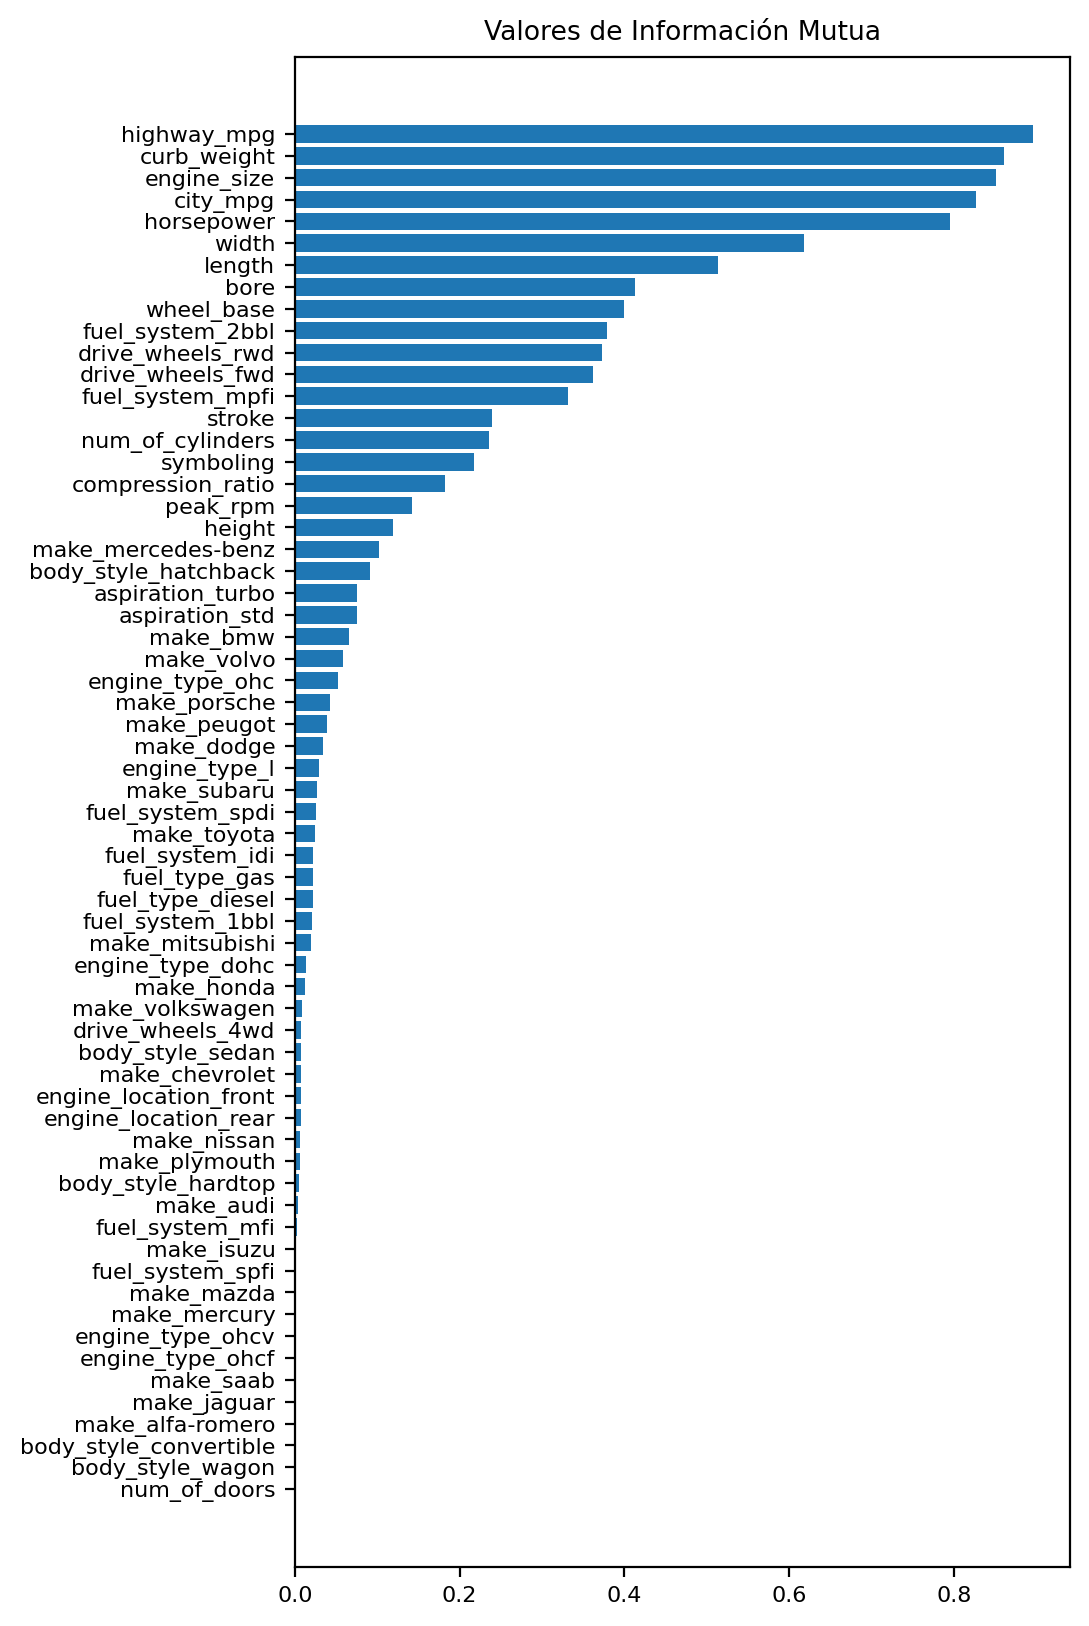

In [134]:
def plot_utility_scores(scores, title):
    y = scores.sort_values(ascending=True)
    width = np.arange(len(y))
    ticks = list(y.index)
    plt.barh(width, y)
    plt.yticks(width, ticks)
    plt.title(title)


plt.figure(dpi=100, figsize=(5, 10))
plt.rc('ytick', labelsize=8) 
plot_utility_scores(mi_scores, title="Valores de Información Mutua")


#### Análisis de las relaciones entre variables

A partir de los valores de MI obtenidos, la visualización de los datos puede ayudarnos a analizar las relaciones entre las variables. Echemos un vistazo a la relación entre la variable de salida y las variables `curb_weight` y `horsepower`, que son las que obtienen la MI más alta.

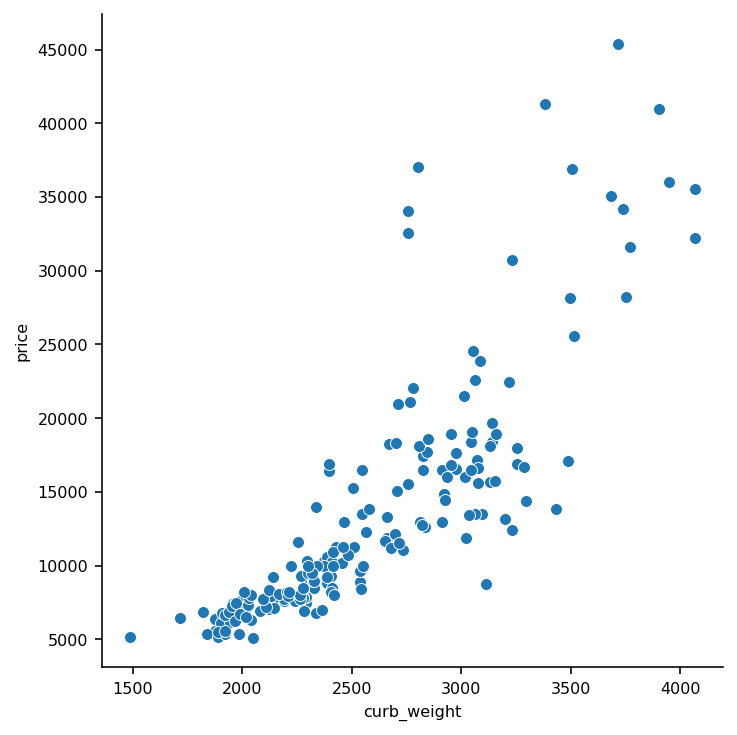

In [135]:
sns.relplot(x="curb_weight", y="price", data=df)

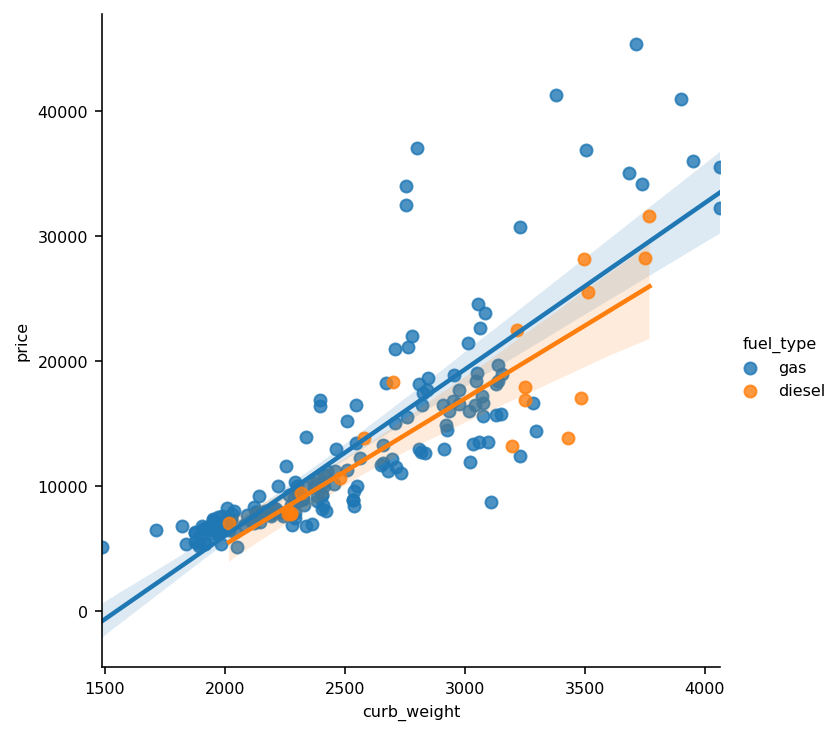

In [138]:
sns.lmplot(x="curb_weight", y="price", hue="fuel_type", data=df);

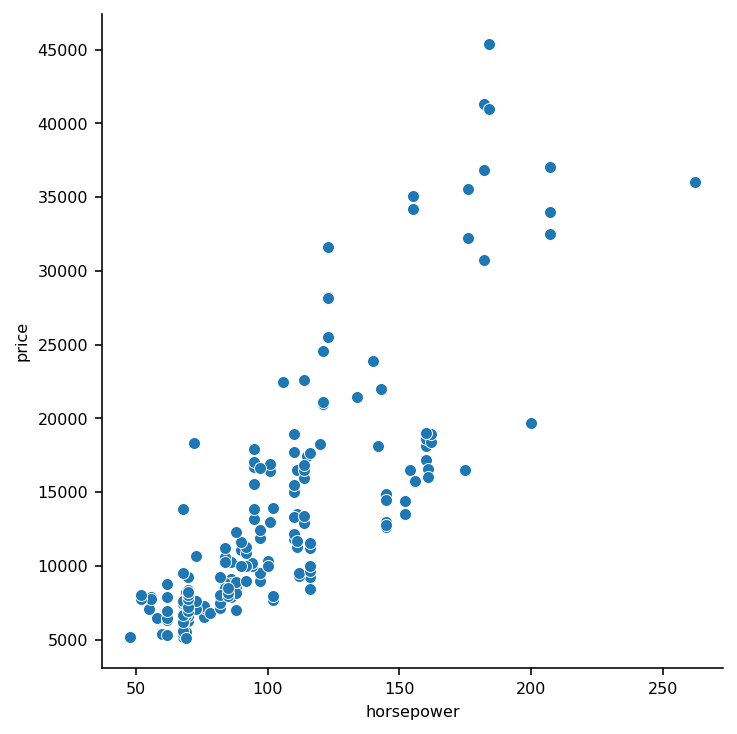

In [136]:
sns.relplot(x="horsepower", y="price", data=df)

En ambos casos comprobamos que estas variables puede ser de gran utilidad para estimar el precio.

Por otro lado, `fuel_type_diesel` o `fuel_type_gas` (una es complementaria de la otra) tienen un valor de MI bastante bajo, lo que nos hace suponer que no van a ser de ayuda y podríamos descartarlas... pero si la dibujamos junto con  `horsepower`

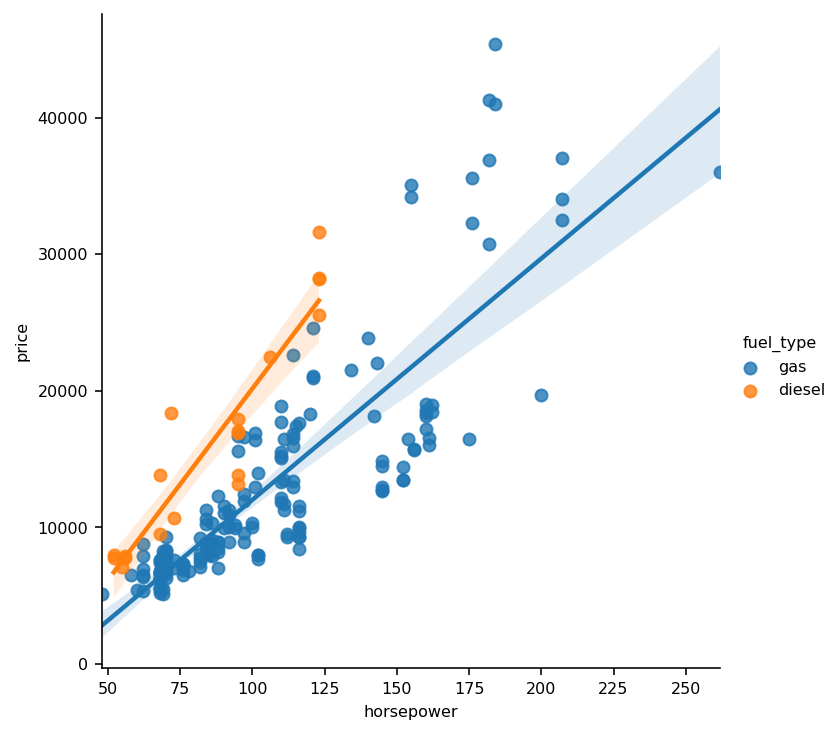

In [137]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

Podemos ver que `fuel_type` separa claramente dos poblaciones de precios con tendencias diferentes dentro de `horsepower`. Esto indica que el tipo de combustible contribuye a un efecto de interacción y podría no ser poco importante después de todo. Antes de decidir que una característica no es importante a partir de su puntuación en el MI, es bueno investigar cualquier posible efecto de interacción: el conocimiento del dominio puede ofrecer mucha orientación en este sentido. 


Por otro lado, este análisis de variables puede ayudarnos a elegir el modelo más adecuado. Si visualizamos la relación entre `highway_mpg` y `price`, ¿qué usaríais para resolver el problema, un modelo lineal o no lineal?

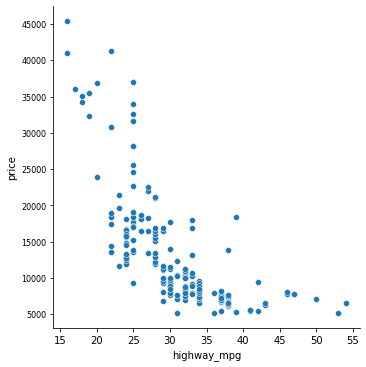

In [13]:
sns.relplot(x="highway_mpg", y="price", data=df)

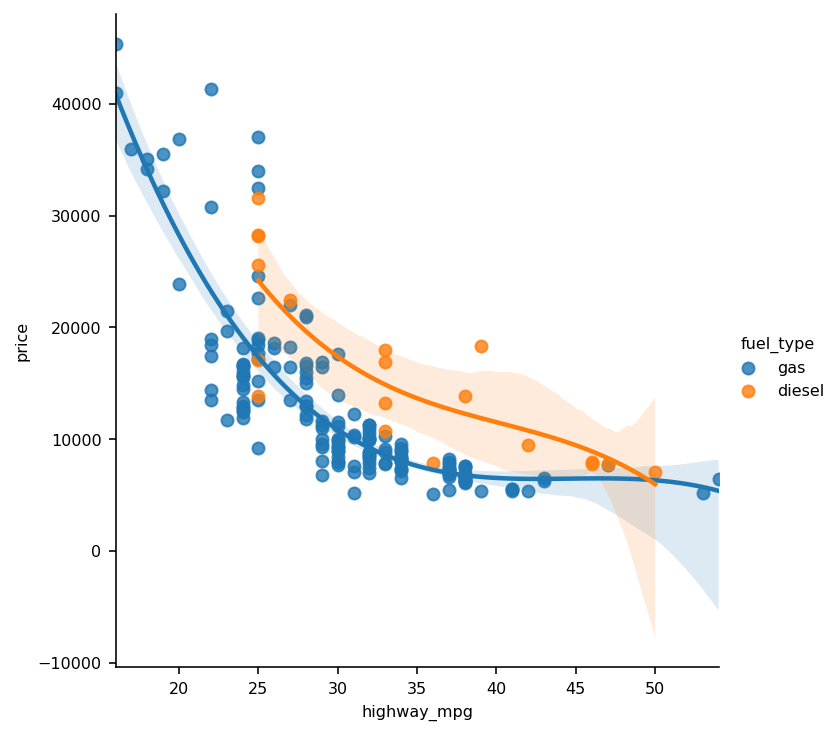

In [142]:
sns.lmplot(x="highway_mpg", y="price", hue="fuel_type", data=df, order=3);

Vemos que un modelo lineal no es la mejor opción y que simplemente una transformación polinómica de orden 2 sobre `highway_mpg` puede darnos mucha ventaja

In [143]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Modelo de regresión lineal
ind_sel = np.where(X.columns=='highway_mpg')[0][0]

LR = LinearRegression(fit_intercept='True').fit(X_train[:, ind_sel][:,np.newaxis], Y_train)
score_LR = LR.score(X_test[:, ind_sel][:,np.newaxis], Y_test)


print("The test R2 with LR is:", score_LR)

# Modelo no lineal
# definamos el grado del polinomio a grado 2
degree =2

# Definimos el pipeline con sus pasos
PolyReg_pipeline = Pipeline(steps=[('Poly', PolynomialFeatures(degree)), ('Norm', StandardScaler()), ('LR', LinearRegression(fit_intercept='True'))])

PolyReg_pipeline.fit(X_train[:, ind_sel][:,np.newaxis], Y_train)
score_LR = PolyReg_pipeline.score(X_test[:, ind_sel][:,np.newaxis], Y_test)
print("The test R2 with poly degree 2 is:", score_LR)

# Modelo no lineal
# definamos el grado del polinomio a grado 3
degree =3

# Definimos el pipeline con sus pasos
PolyReg_pipeline = Pipeline(steps=[('Poly', PolynomialFeatures(degree)), ('Norm', StandardScaler()), ('LR', LinearRegression(fit_intercept='True'))])

PolyReg_pipeline.fit(X_train[:, ind_sel][:,np.newaxis], Y_train)
score_LR = PolyReg_pipeline.score(X_test[:, ind_sel][:,np.newaxis], Y_test)
print("The test R2 with poly degree 3 is:", score_LR)

The test R2 with LR is: 0.4692058236798581
The test R2 with poly degree 2 is: 0.7297616153102642
The test R2 with poly degree 3 is: 0.7661884259295724


#### Ranking de variables

Ahora, podemos usar este ranking y analizar las prestaciones de un regresor en función del número de variables que usemos...

In [144]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

def R2_evolution(X_train_s, Y_train, X_test_s, Y_test, rang_feat):
    """Compute the R2 over validation and test data for different the number of features given
        in rang_feat.

    Args:
        X_train_s (numpy dnarray): training data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_train (numpy dnarray): labels of the training data (number data x 1).
        X_test_s (numpy dnarray): test data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_test (numpy dnarray): labels of the test data (number data x 1).
        rang_feat: range with different number of features to be evaluated                                           
   
    """
    
    # Define the model to train and adjust by CV the free parameters
    model = KNeighborsRegressor()
    R2_val = []
    R2_test = []
    param_grid = {
    'n_neighbors': range(1,10),
    'weights':['uniform','distance'],
    }
    grid= GridSearchCV(model, param_grid, cv=10)

    for i in rang_feat:
        # Train SVM classifier
        grid.fit(X_train_s[:, :i], Y_train)
        # Compute R2
        R2_val.append(grid.best_score_)
        R2_test.append(grid.score(X_test_s[:, :i], Y_test))

    return np.array(R2_val), np.array(R2_test)


def plot_R2_evolution(rang_feat, R2_val, R2_test):

    """Plot the R2 evolution for training, validation and test data sets.
    Args:
        rang_feat: range with different number of features where the R2 has been evaluated   
        R2_val: numpy vector with the validation R2
        R2_test: numpy vector with the test R2                                       
    """

    plt.plot(rang_feat, R2_val, "b", label="validation")
    plt.plot(rang_feat, R2_test, "r", label="test")
    plt.xlabel("Number of features")
    plt.ylabel("R2")
    plt.title('R2 evolution')
    plt.legend(['Validation', 'Test'], loc = 4)

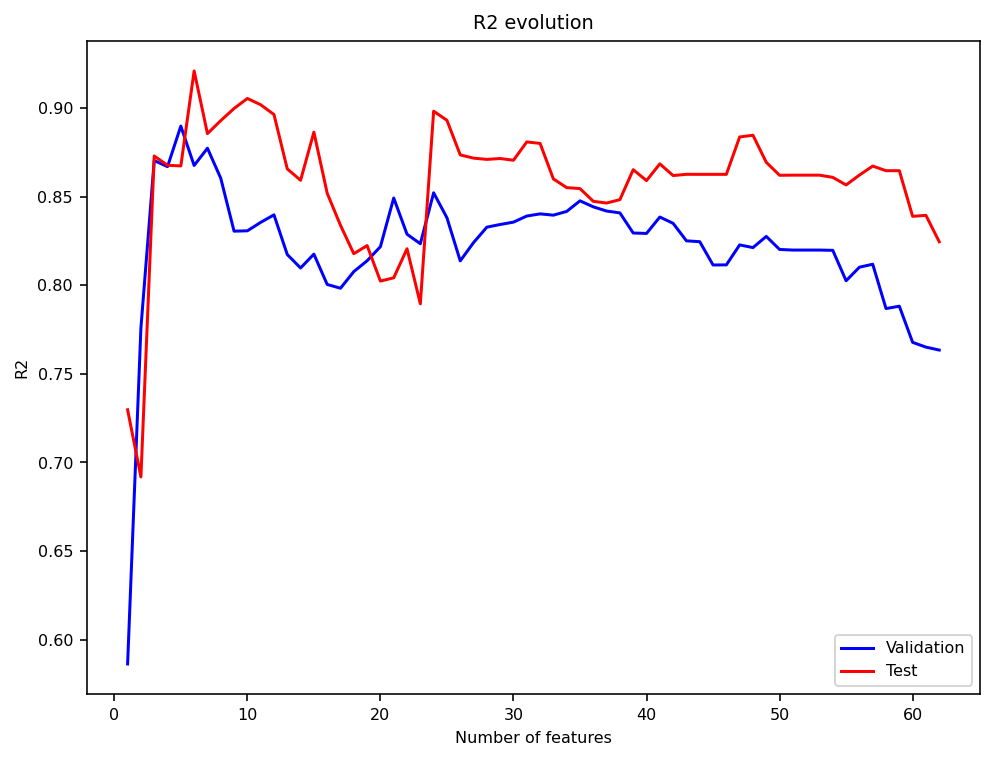

Number selected of features:  5
The test R2 is  0.87


In [145]:
# Define the range of features to explore
rang_feat = np.arange(1, X.shape[1]) 
[R2_val, R2_test] = R2_evolution(X_train[:, ind_rel_feat], Y_train, X_test[:, ind_rel_feat], Y_test, rang_feat)

# Plot the results
plt.figure()
plot_R2_evolution(rang_feat, R2_val, R2_test)
plt.show()

# Find the CV number of features
pos_max = np.argmax(R2_val)
num_feat = rang_feat[pos_max]
test_R2 = R2_test[pos_max]

print('Number selected of features:  %d' %(num_feat))
print("The test R2 is  %2.2f" %(test_R2))


También podemos incluir la selección de características en un pipeline de ML usando `SelectBestK()` junto con un pipeline y cross validar los diferentes parámetros con GridSearch.

In [148]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
param_grid = {
    'FS__k' : range(10, 60, 5),
    'KNN__n_neighbors': range(5,10,2),
    'KNN__weights':['uniform'],#['uniform','distance'],
    }

def my_score(X, y):
    return mutual_info_regression(X, y, discrete_features=discrete_features) 


pipe = Pipeline([('FS', SelectKBest(my_score)), ('KNN', KNeighborsRegressor())])
grid_pipe = GridSearchCV(pipe, param_grid, cv=10)
grid_pipe.fit(X_train, Y_train)
print(grid_pipe.best_params_)

R2_test = grid_pipe.score(X_test, Y_test)
print("R2 over test data: {0:.2f}".format(R2_test))

{'FS__k': 40, 'KNN__n_neighbors': 5, 'KNN__weights': 'uniform'}
R2 over test data: 0.84


**Resumen:**

La información mutua es una gran métrica de uso general y especialmente útil para la selección de características e, incluso, para su análisis, cuando es posible que aún no se sepa qué modelo se va a utilizar. Además, es

*  fácil de usar e interpretar,
*  eficiente desde el punto de vista computacional,
*  teóricamente bien fundada,
*  capaz de detectar cualquier tipo de relación

Sin embargo, cuando vayamos a usarla, debemos tener en cuenta:
*  La información mutua nos puede indicar el potencial individual de cada característica para predecir nuestra variable objetivo.
*  Es posible que una característica sea muy informativa cuando interactúa con otras características, pero no tan informativa por sí sola. El MI no puede detectar interacciones entre características. Es una métrica **univariante**.
*  La utilidad real de una característica depende del modelo con el que se utilice. Una característica sólo es útil en la medida en que su relación con el objetivo sea una que su modelo pueda aprender. El hecho de que una característica tenga una puntuación alta en el MI no significa que su modelo pueda hacer algo con esa información. Es posible que tenga que transformar la característica primero para exponer la asociación.



### Criterios multivariantes

Los ejemplos anteriores muestran que es razonable seleccionar subconjuntos de variables que en conjunto tengan un buen poder de predicción, en vez de seleccionar las variables según su poder de predicción individual. Para ello, necesitamos **criterios de variables multivariante**. 

Todos los medidas de relevancia que incluye sklearn son univariantes, pero podemos usarlos o adaptarlos para intentar aproximarnos a un esquema multivariante tal y como have el método de Mínima Redundacia y Máxima Relevancia.

#### Método de Minima Redundancia y  Maxima Relevancia (mrMR)

El método mrMR es una estrategia para usar medidas de relevancia univariantes dentro de un análisis multivariante. La idea de este método se basa en el uso de la búsqueda incremental en la que en cada paso añadimos la variable que es más relevante (con la tarea de salida) y tiene la menor redundancia con las características ya seleccionadas. 

Podemos resumir su funcionamiento con el siguiente pseudocódigo:
1. Seleccionar medidas de relevancia y redundancia ($R_{\rm REL}$, $R_{\rm RED}$)
2. Definir $var_{\rm sel} = \left\lbrace \right\rbrace $; $var_{\rm  cand} =\left\lbrace X_1, \ldots, X_D\right\rbrace$
3. Iterar sobre $D$ iteraciones:
  
  3.1. Iterar i sobre $var_{\rm  cand}$ y calcular:
    $$ {\rm Relevance}(i) = R_{\rm REL} \left(X_i, Y\right) $$
$$ {\rm Redundancy}(i) =\displaystyle \sum_{i' \in var_{\rm sel}}  R_{\rm RED} \left(X_i, X_{i'}\right) $$
$${\rm mrMR}(i)= {\rm Relevance}(i) - {\rm Redundancy}(i)$$

  3.2. Obtener 
$$i^{*} = \underset{i}{\operatorname{argmax}} ~{\rm mrMR}(i)$$ 
  3.3 Añade $i^{*}$ a $var_{\rm sel}$ y eliminalo de $var_{\rm  cand}$.


Veamos cómo aplicar este método usando la **información mútua** como criterio de relevancia y la **correlación** como medida de redundancia.


In [149]:
# Variable initialization
n_var = X_train.shape[1]
var_sel = np.empty(0,dtype=int) # subset of selected features
var_cand = np.arange(n_var) # subset of candidate features

# Precompute relevances 
relevances = mutual_info_regression(X_train, Y_train, discrete_features=discrete_features)

# Precomupute redundancies (correlation among all input variables, it is a matrix of n_var x n_var)
redundancies = np.abs(np.cov(X_train.T))

# Select the most relevant feature
sel = np.argmax(relevances)
# Add it to the subset of selected features
var_sel = np.hstack([var_sel,sel])
# Remove it from the subset of candidate features
var_cand = np.delete(var_cand,sel)

MRmr_values= [relevances[sel]]

# Iteratively select variables
for i in range(n_var-1):
    # Get relevance values of the var_cand variables
    relevances_cand=relevances[var_cand]
    
    # Compute redundancies with selected features:
    # from the redundancies matrix select the rows of var_sel and the columns of var_cand
    redundancy_sel = redundancies[np.ix_(var_sel,var_cand)]    
    # Average the redundancy values over the selected features (rows) 
    # to get a redundancy value for each candidate variables   
    redundancy_cand=np.mean(redundancy_sel,axis=0)
    
    # Compute MRmr = relevances_cand - redundancy_cand
    MRmr=relevances_cand-redundancy_cand
    
    # Select the new feature as the one with the maximum MRmr value
    sel=np.argmax(MRmr)
    MRmr_values.append(MRmr[sel])
    # Add it to the subset of selected features
    var_sel=np.hstack([var_sel,var_cand[sel]])
    # Remove it from the subset of candidate features
    var_cand= np.delete(var_cand,sel)

ind_rel_feat = var_sel



In [150]:
mi_scores_MRmr = pd.Series(MRmr_values, index =X.columns[ind_rel_feat]) 
mi_scores_MRmr

highway_mpg             0.901592
stroke                  0.208172
engine_size             0.402829
curb_weight             0.248102
horsepower              0.184607
                          ...   
engine_location_rear   -0.132678
fuel_type_diesel       -0.137236
engine_type_ohc        -0.141625
num_of_doors           -0.148135
fuel_system_idi        -0.151181
Length: 63, dtype: float64

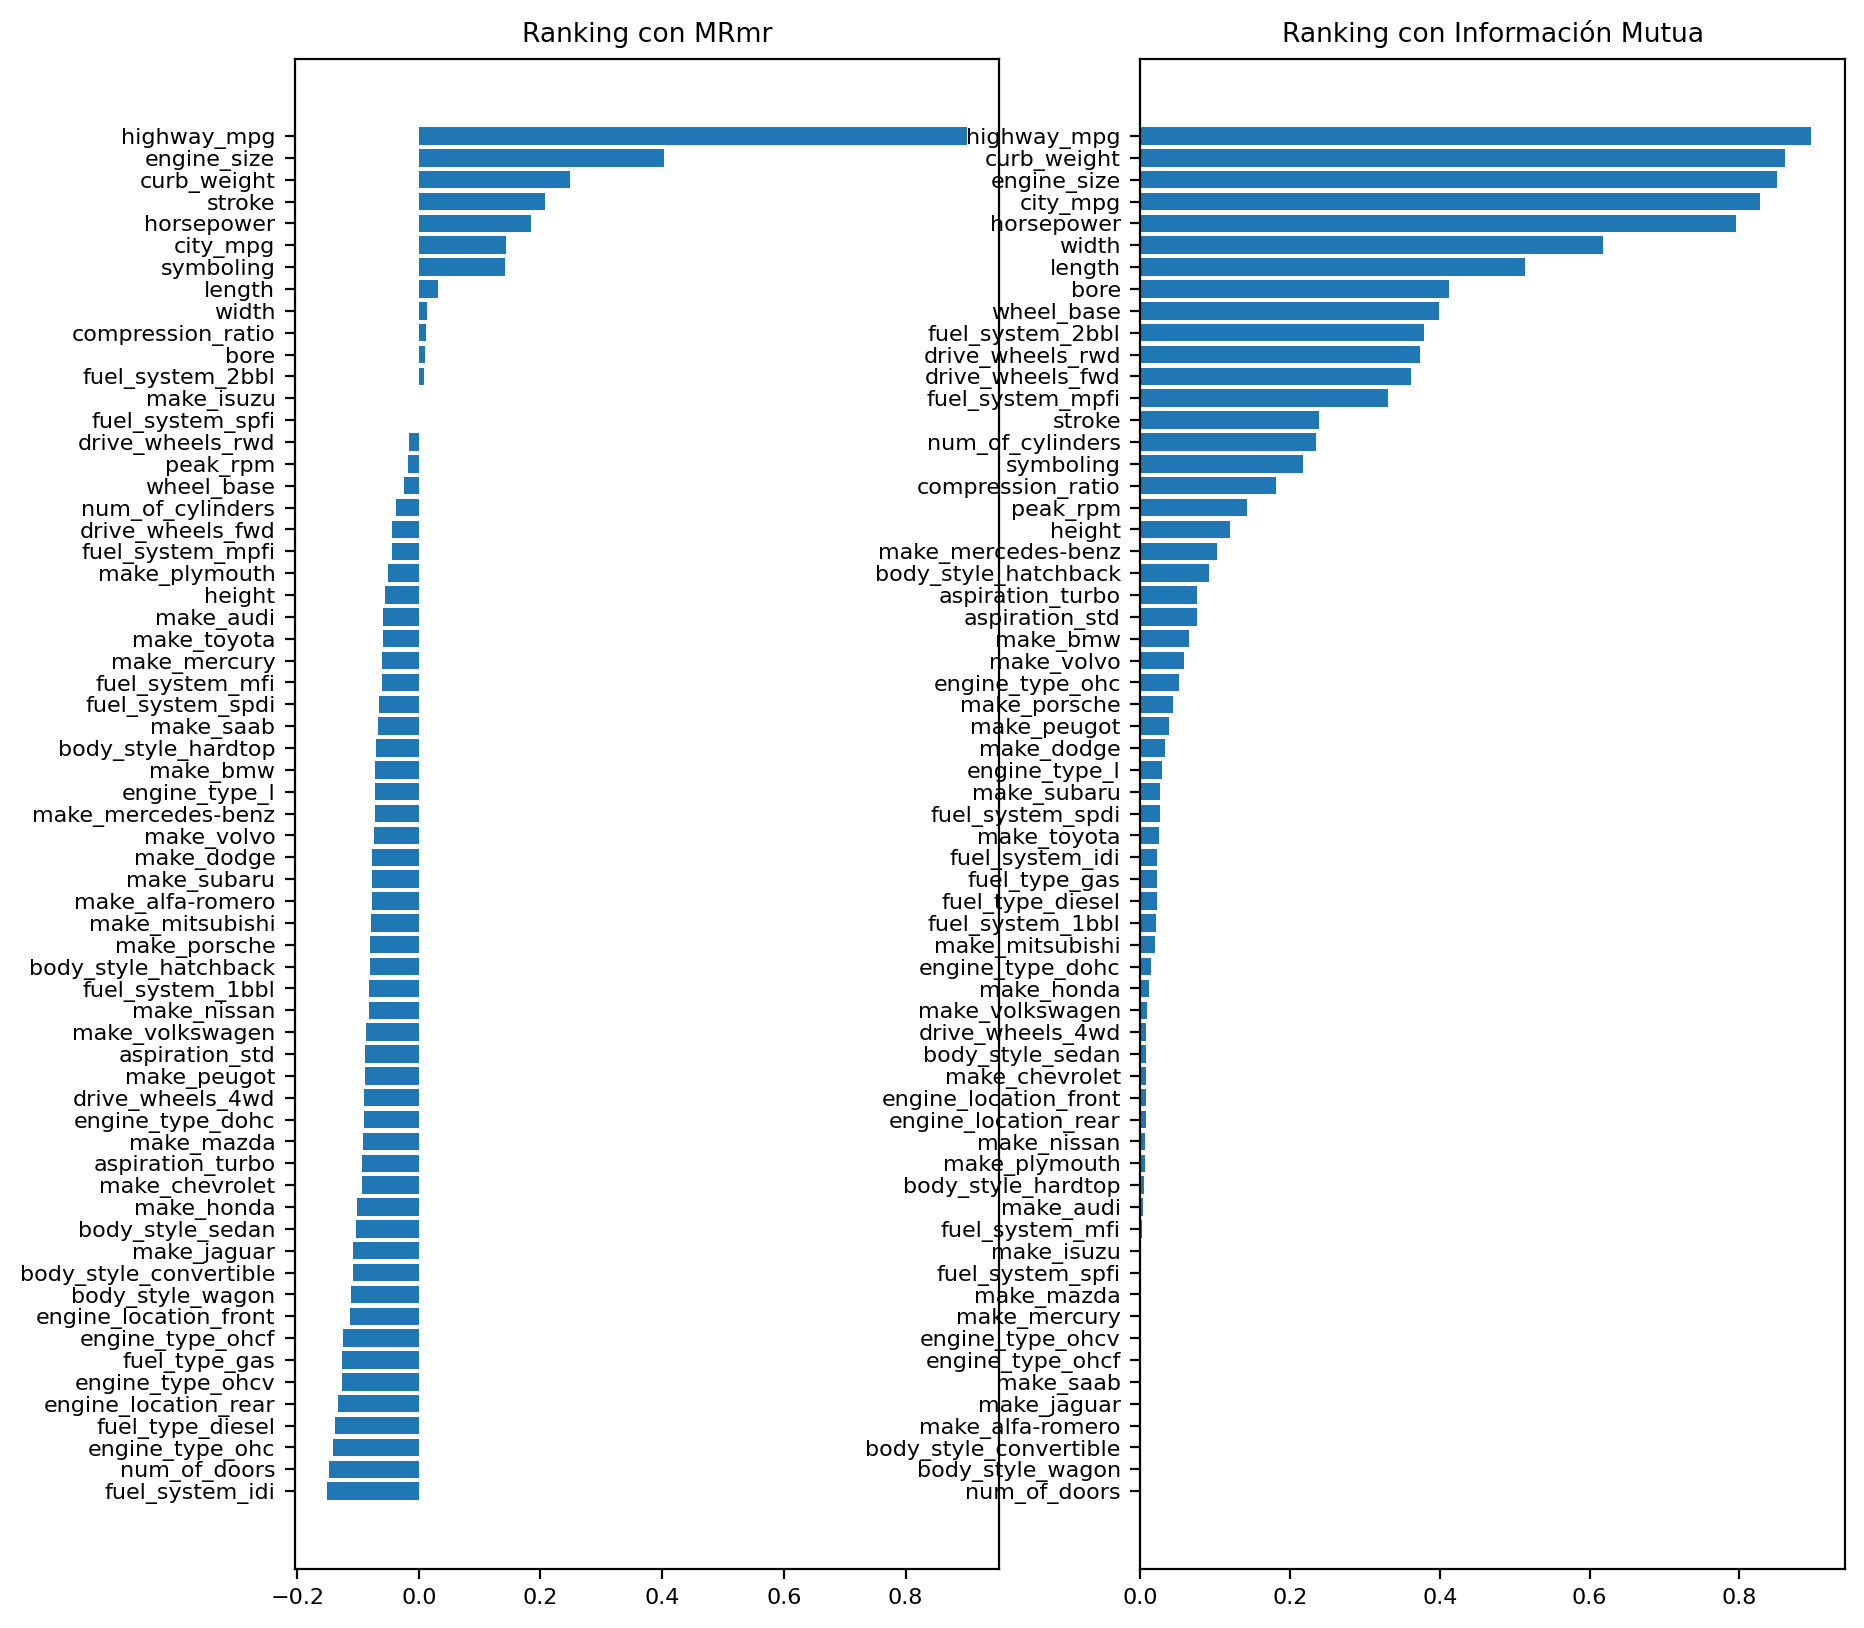

In [151]:
plt.figure(dpi=100, figsize=(10, 10))
plt.subplot(1,2,1)
plt.rc('ytick', labelsize=8) 
plot_utility_scores(mi_scores_MRmr, title="Ranking con MRmr")
plt.subplot(1,2,2)
plot_utility_scores(mi_scores, title="Ranking con Información Mutua")

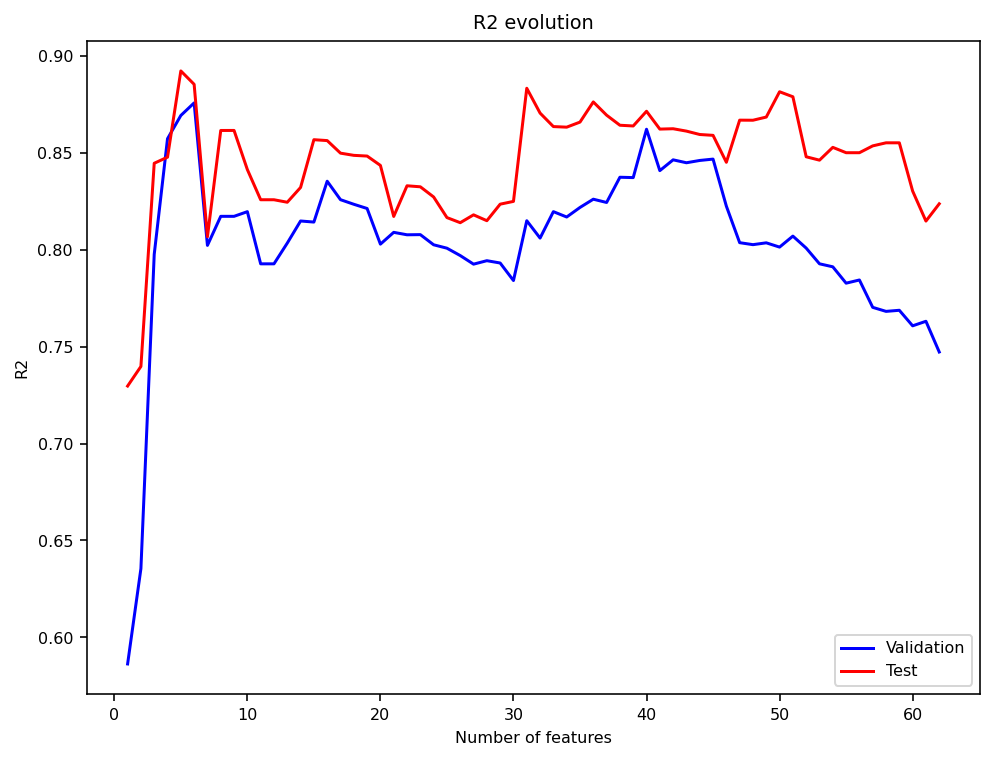

Number of selected features:  6
The test R2 is  0.89


In [152]:
# Define the range of features to explore
rang_feat = np.arange(1, X.shape[1]) 
[R2_val, R2_test] = R2_evolution(X_train[:, ind_rel_feat], Y_train, X_test[:, ind_rel_feat], Y_test, rang_feat)

# Plot the results
plt.figure()
plot_R2_evolution(rang_feat, R2_val, R2_test)
plt.show()

# Find the CV number of features
pos_max = np.argmax(R2_val)
num_feat = rang_feat[pos_max]
test_R2 = R2_test[pos_max]

print('Number of selected features:  %d' %(num_feat))
print("The test R2 is  %2.2f" %(test_R2))

## Métodos *Wrapper*

Los métodos *wrapper* utilizan directamente el rendimiento del clasificador/regresor final para evaluar la capacidad predictiva de los diferentes subconjuntos de características. 

Para ello, normalmente, utilizan una partición de validación (o un proceso CV n-fold) para analizar iterativamente la relevancia de los diferentes subconjuntos de características.

No obstante, si queremos encontrar el mejor subconjunto de características debemos explorar todos los subconjuntos de características posibles. Sin embargo, esta búsqueda exhaustiva es normalmente inabordable (con $D$ características tenemos $2^D-1$ subconjuntos posibles a explorar!!!). Por este motivo, se suelen hacer búsquedas *greedy*:
* **Búsqueda incremental** donde empezamos con un conjunto vacío e iterativamente, añadimos nuevas características según un criterio de relevancia.

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/FeatureSelection/FS_2es.png" width="60%" > 
* **Eliminación Recursiva de Variables** (RFE, *Recursive Feature Elimination*) donde empezamos  considerando todas las características e iterativamente, eliminamos características según un criterio de relevancia.


<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/FeatureSelection/FS_3es.png" width="60%" > 


Otras implementaciones de los wrappers utilizan algunos parámetros del modelo predictivo que son capaces de indicar la relevancia de las características. Por ejemplo, en los modelos lineales, los pesos del modelo pueden utilizarse como indicación de la importancia de cada variable; cuanto mayor sea el peso (absoluto), más relevante será la característica.

De hecho, sklearn incluye una implementación wrapper con una búsqueda RFE para cualquier clasificador que tenga algún indicador de relevancia de las variables, ya sea mediante los pesos de modelo (`coef`) o directamente `importancia_de_características_`. El código de la siguiente celda muestra cómo usarlo usando un regresor lineal como modelo! Para este ejemplo le indicamos que use 10 características.

In [153]:
from sklearn.feature_selection import RFE

LR = LinearRegression(fit_intercept='True')
selector = RFE(LR, n_features_to_select=10, step=1)
selector = selector.fit(X_train, Y_train)

# Print selected features
X.columns[selector.support_] 


Index(['width', 'curb_weight', 'num_of_cylinders', 'engine_size', 'bore',
       'stroke', 'make_bmw', 'make_peugot', 'engine_location_front',
       'engine_type_l'],
      dtype='object')

También podemos obtener el ranking de todas las variables. Para ello volvemos a entrenar el modelo pero indicando que elija el 100% de variables y en el atributo `.ranking_` tenemos lo que buscamos

In [154]:
selector = RFE(LR, n_features_to_select=1, step=1) 
selector = selector.fit(X_train, Y_train)

ranking_RFE = pd.Series(1./selector.ranking_, index =X.columns) 
ranking_RFE.sort_values()[::-1]

engine_size              1.000000
curb_weight              0.500000
engine_location_front    0.333333
make_bmw                 0.250000
width                    0.200000
                           ...   
num_of_doors             0.016949
fuel_system_spdi         0.016667
make_isuzu               0.016393
horsepower               0.016129
fuel_system_spfi         0.015873
Length: 63, dtype: float64

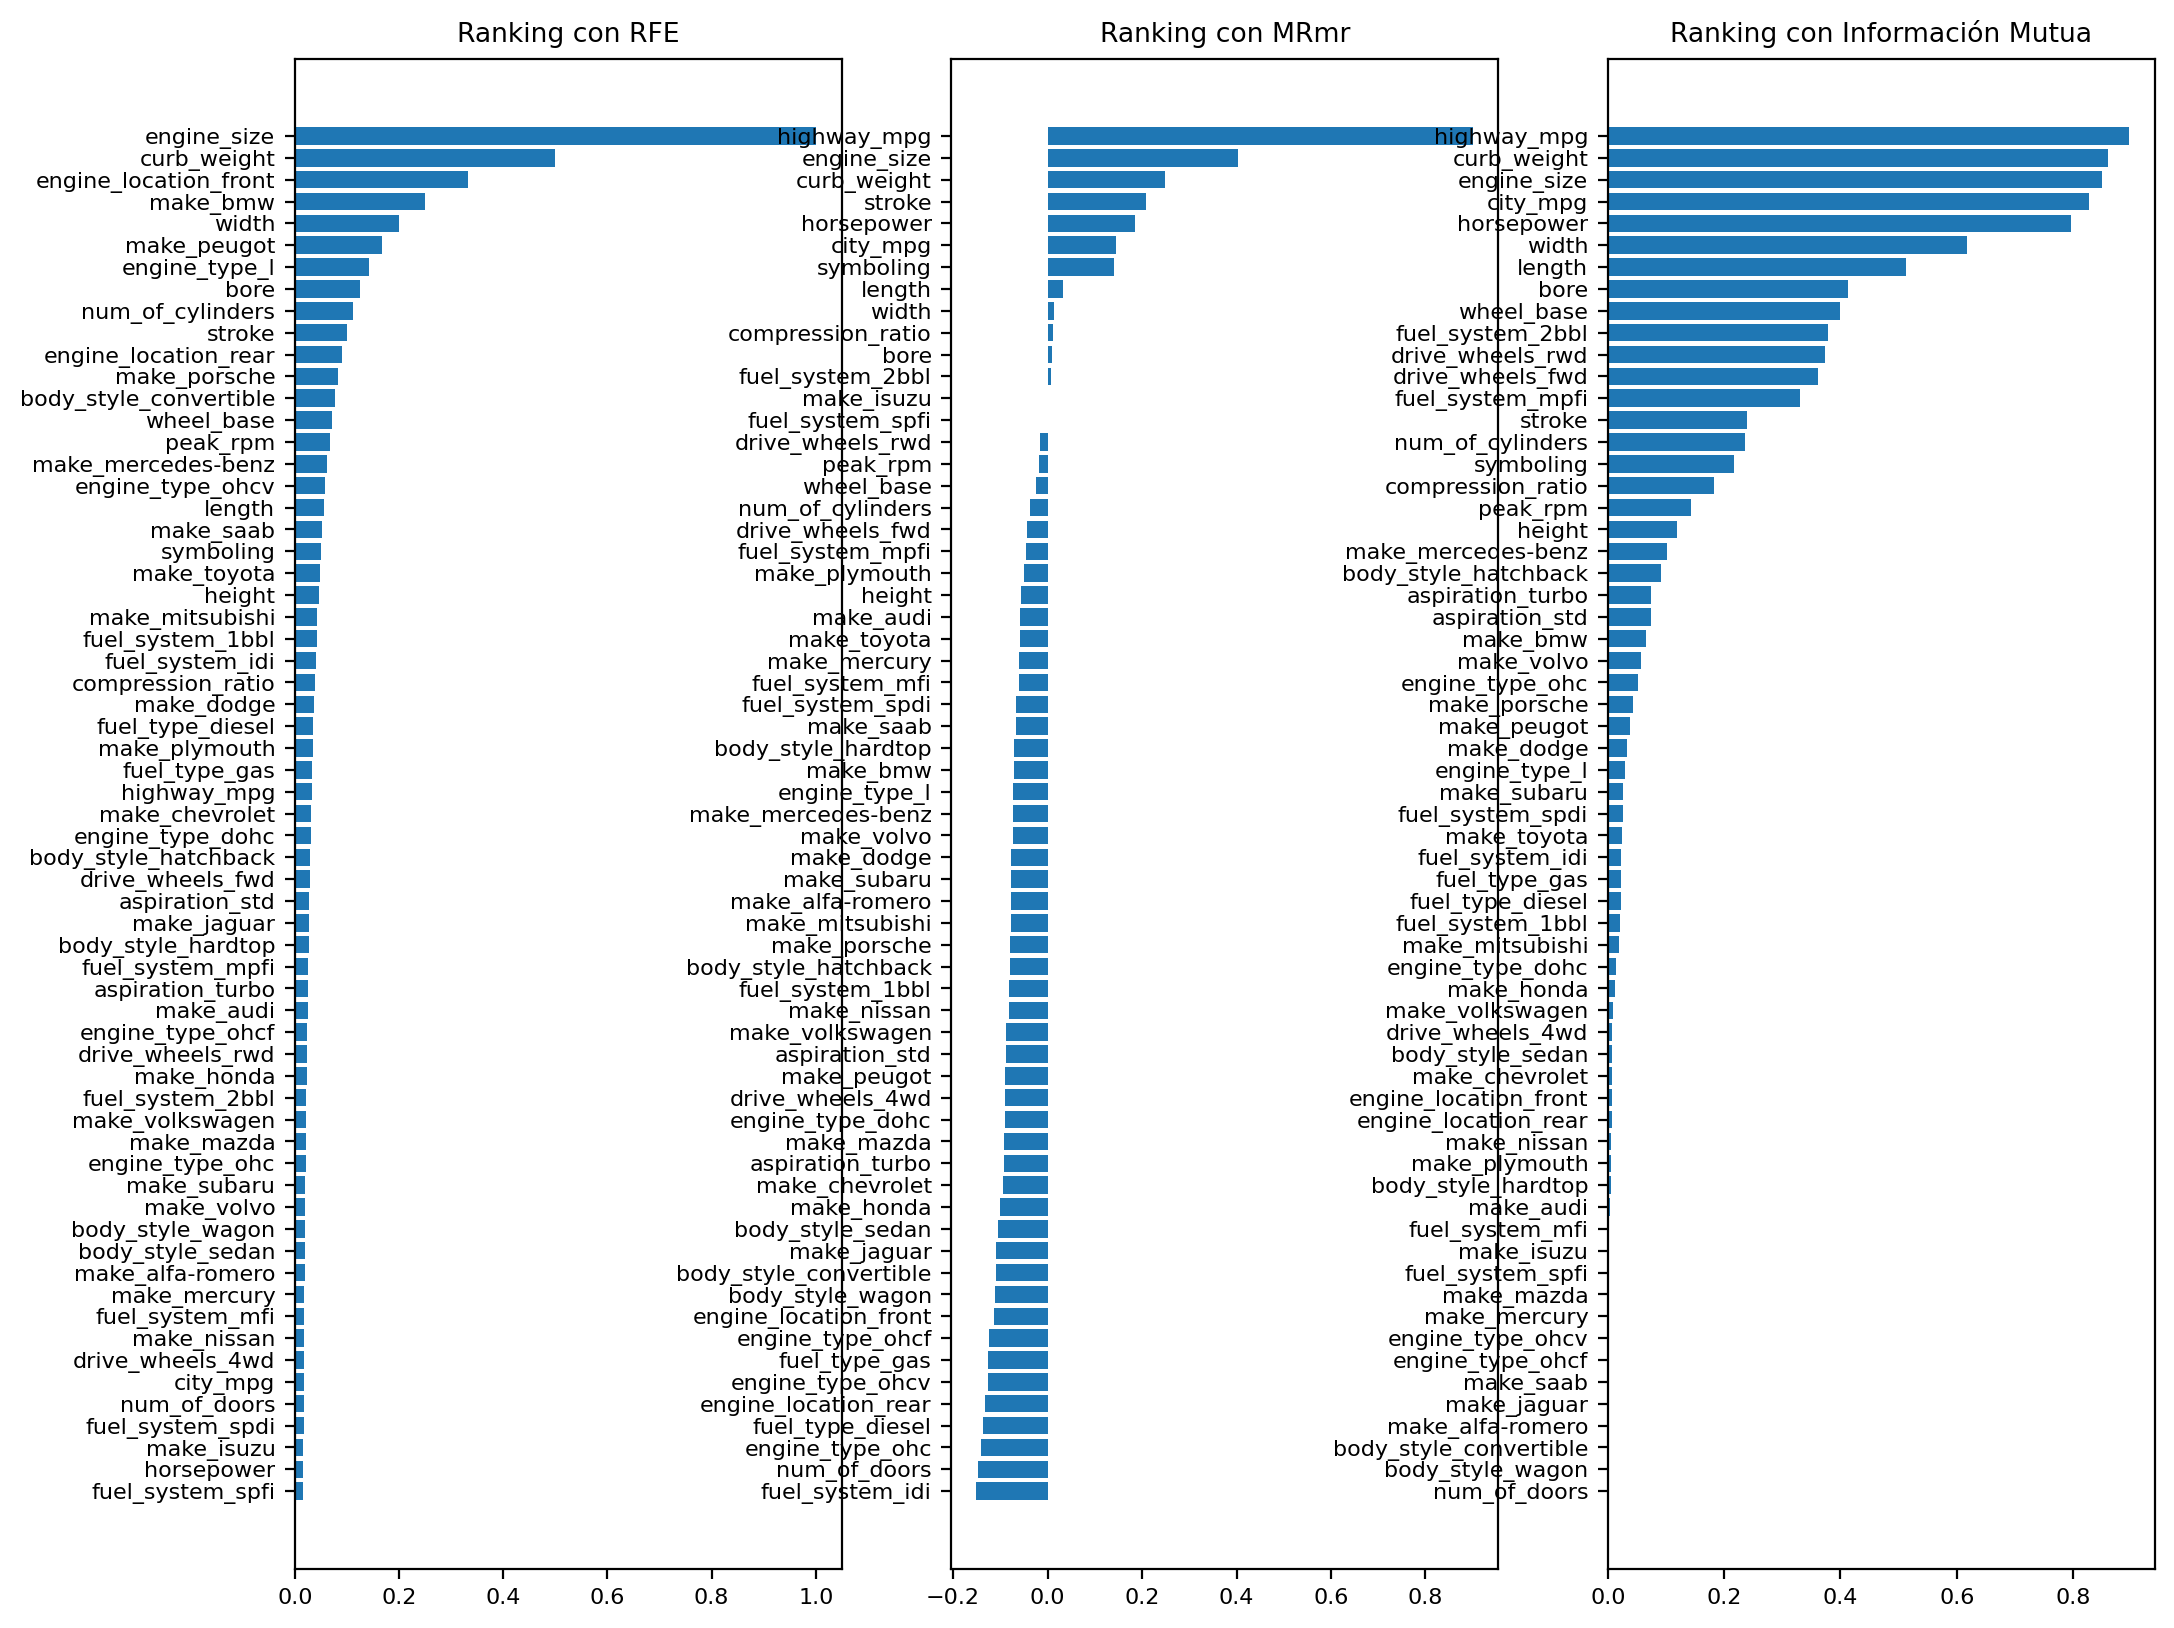

In [155]:
plt.figure(dpi=100, figsize=(12, 10))
plt.subplot(1,3,1)
plt.rc('ytick', labelsize=8) 
plot_utility_scores(ranking_RFE, title="Ranking con RFE")
plt.subplot(1,3,2)
plot_utility_scores(mi_scores_MRmr, title="Ranking con MRmr")
plt.subplot(1,3,3)
plot_utility_scores(mi_scores, title="Ranking con Información Mutua")

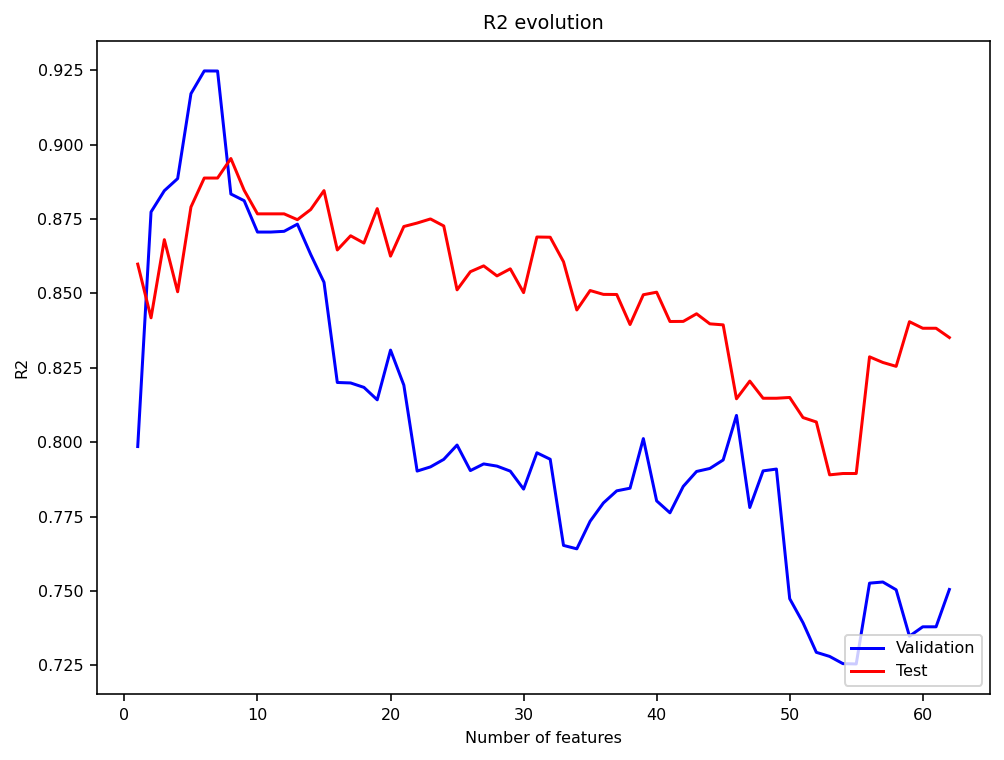

Number optimum of features:  6
The optimum test R2 is  0.89


In [156]:
# Define the range of features to explore
ind_rel_feat = np.argsort(selector.ranking_)
rang_feat = np.arange(1, X.shape[1]) 
[R2_val, R2_test] = R2_evolution(X_train[:, ind_rel_feat], Y_train, X_test[:, ind_rel_feat], Y_test, rang_feat)

# Plot the results
plt.figure()
plot_R2_evolution(rang_feat, R2_val, R2_test)
plt.show()

# Find the optimum number of features
pos_max = np.argmax(R2_val)
num_opt_feat = rang_feat[pos_max]
test_R2_opt = R2_test[pos_max]

print('Number optimum of features:  %d' %(num_opt_feat))
print("The optimum test R2 is  %2.2f" %(test_R2_opt))

Con lo que sabemos del problema, ¿se te ocurre alguna limitacióón en esta aproximación?
Hemos usado un modelo lineal dentro del RFE para hacer la selección, por lo que las variables con relaciones no lineales, no serán seleccionadas entre las primeras

**Solución**: Usar otro modelo para la selección, por ejemplo, `DecisionTree` o `RandomForest`, que sí analizan relaciones no lineales.



In [159]:
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor()
selector = RFE(DT, n_features_to_select=1, step=1) 
selector = selector.fit(X_train, Y_train)

ranking_RFE = pd.Series(1./selector.ranking_, index =X.columns) 
ranking_RFE.sort_values()[::-1]

engine_size         1.000000
curb_weight         0.500000
horsepower          0.333333
length              0.250000
width               0.200000
                      ...   
make_plymouth       0.016949
fuel_system_spdi    0.016667
make_porsche        0.016393
symboling           0.016129
fuel_system_spfi    0.015873
Length: 63, dtype: float64

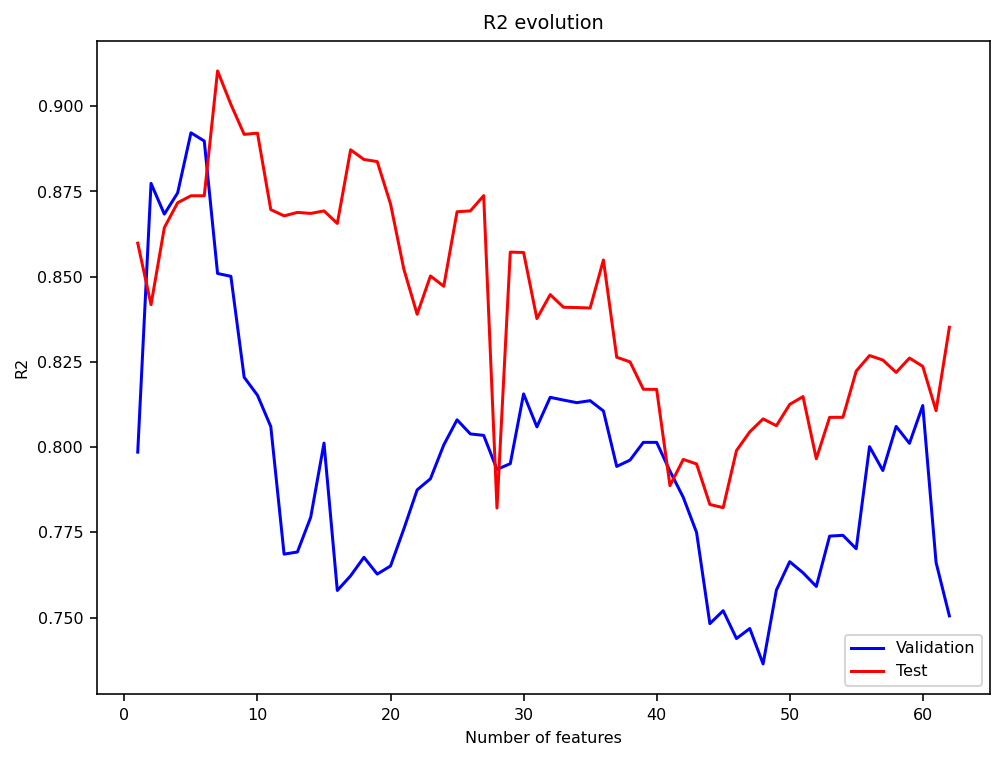

Number of features with cross-validation:  5
The optimum test R2 is  0.87


In [160]:
# Define the range of features to explore
ind_rel_feat = np.argsort(selector.ranking_)
rang_feat = np.arange(1, X.shape[1]) 
[R2_val, R2_test] = R2_evolution(X_train[:, ind_rel_feat], Y_train, X_test[:, ind_rel_feat], Y_test, rang_feat)

# Plot the results
plt.figure()
plot_R2_evolution(rang_feat, R2_val, R2_test)
plt.show()

# Find the optimum number of features
pos_max = np.argmax(R2_val)
num_opt_feat = rang_feat[pos_max]
test_R2_opt = R2_test[pos_max]

print('Number of features with cross-validation:  %d' %(num_opt_feat))
print("The optimum test R2 is  %2.2f" %(test_R2_opt))

## Métodos *Embedded*

Los métodos *embedded* son capaces de llevar a cabo el proceso de selección de características durante el entrenamiento del clasificador, por lo que ambas etapas (selección de características y entrenamiento del clasificador) están completamente vinculadas y, por lo tanto, el proceso de selección está guiado por el clasificador.

Aquí, vamos a analizar dos enfoques: 
* Random Forests
* Regularización L1


### Random Forest

Como sabeis, un Random Forest (RF) entrena varios árboles de decisión/estimación, donde cada uno de ellos se entrena con diferentes subconjuntos de muestras y características y, a continuación, obtiene la predicción final para las muestras de test combinando (promediando) las predicciones individuales de cada árbol. 

Podemos utilizar los RF para evaluar la importancia de las características en una tarea predictiva. Obsérvese que la profundidad de una característica dentro de un árbol nos proporciona una importancia relativa de esa característica. Analizando esta información sobre todos los árboles de un RF, podemos obtener una buena estimación de la capacidad de predicción de cada característica y utilizarla para la selección de características. 

Las funciones [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) y [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) devuelven la relevancia de cada característica en la variable `feature_importances_`. Esta variable es una matriz con tamaño `(n_features,)` cuyos valores son positivos y suman 1.0. Cuanto más alto es el valor, más importante es la contribución de la característica en la función de predicción del RF.


In [161]:
from sklearn.ensemble import RandomForestRegressor
np.random.seed(1)
# Build a forest and obtain the feature importances
forest = RandomForestRegressor(n_estimators=200)
forest.fit(X_train, Y_train)
importances = forest.feature_importances_

# Obtain the positions of the sorted features (the most relevant first)
ind_rel_feat = np.argsort(importances)[::-1]

# Print the feature ranking
ranking_RF = pd.Series(importances[ind_rel_feat], index =X.columns[ind_rel_feat]) 
ranking_RF


engine_size         0.664638
curb_weight         0.168861
highway_mpg         0.037490
horsepower          0.017064
city_mpg            0.016902
                      ...   
make_mercury        0.000009
fuel_system_1bbl    0.000006
make_chevrolet      0.000003
make_isuzu          0.000000
fuel_system_spfi    0.000000
Length: 63, dtype: float64

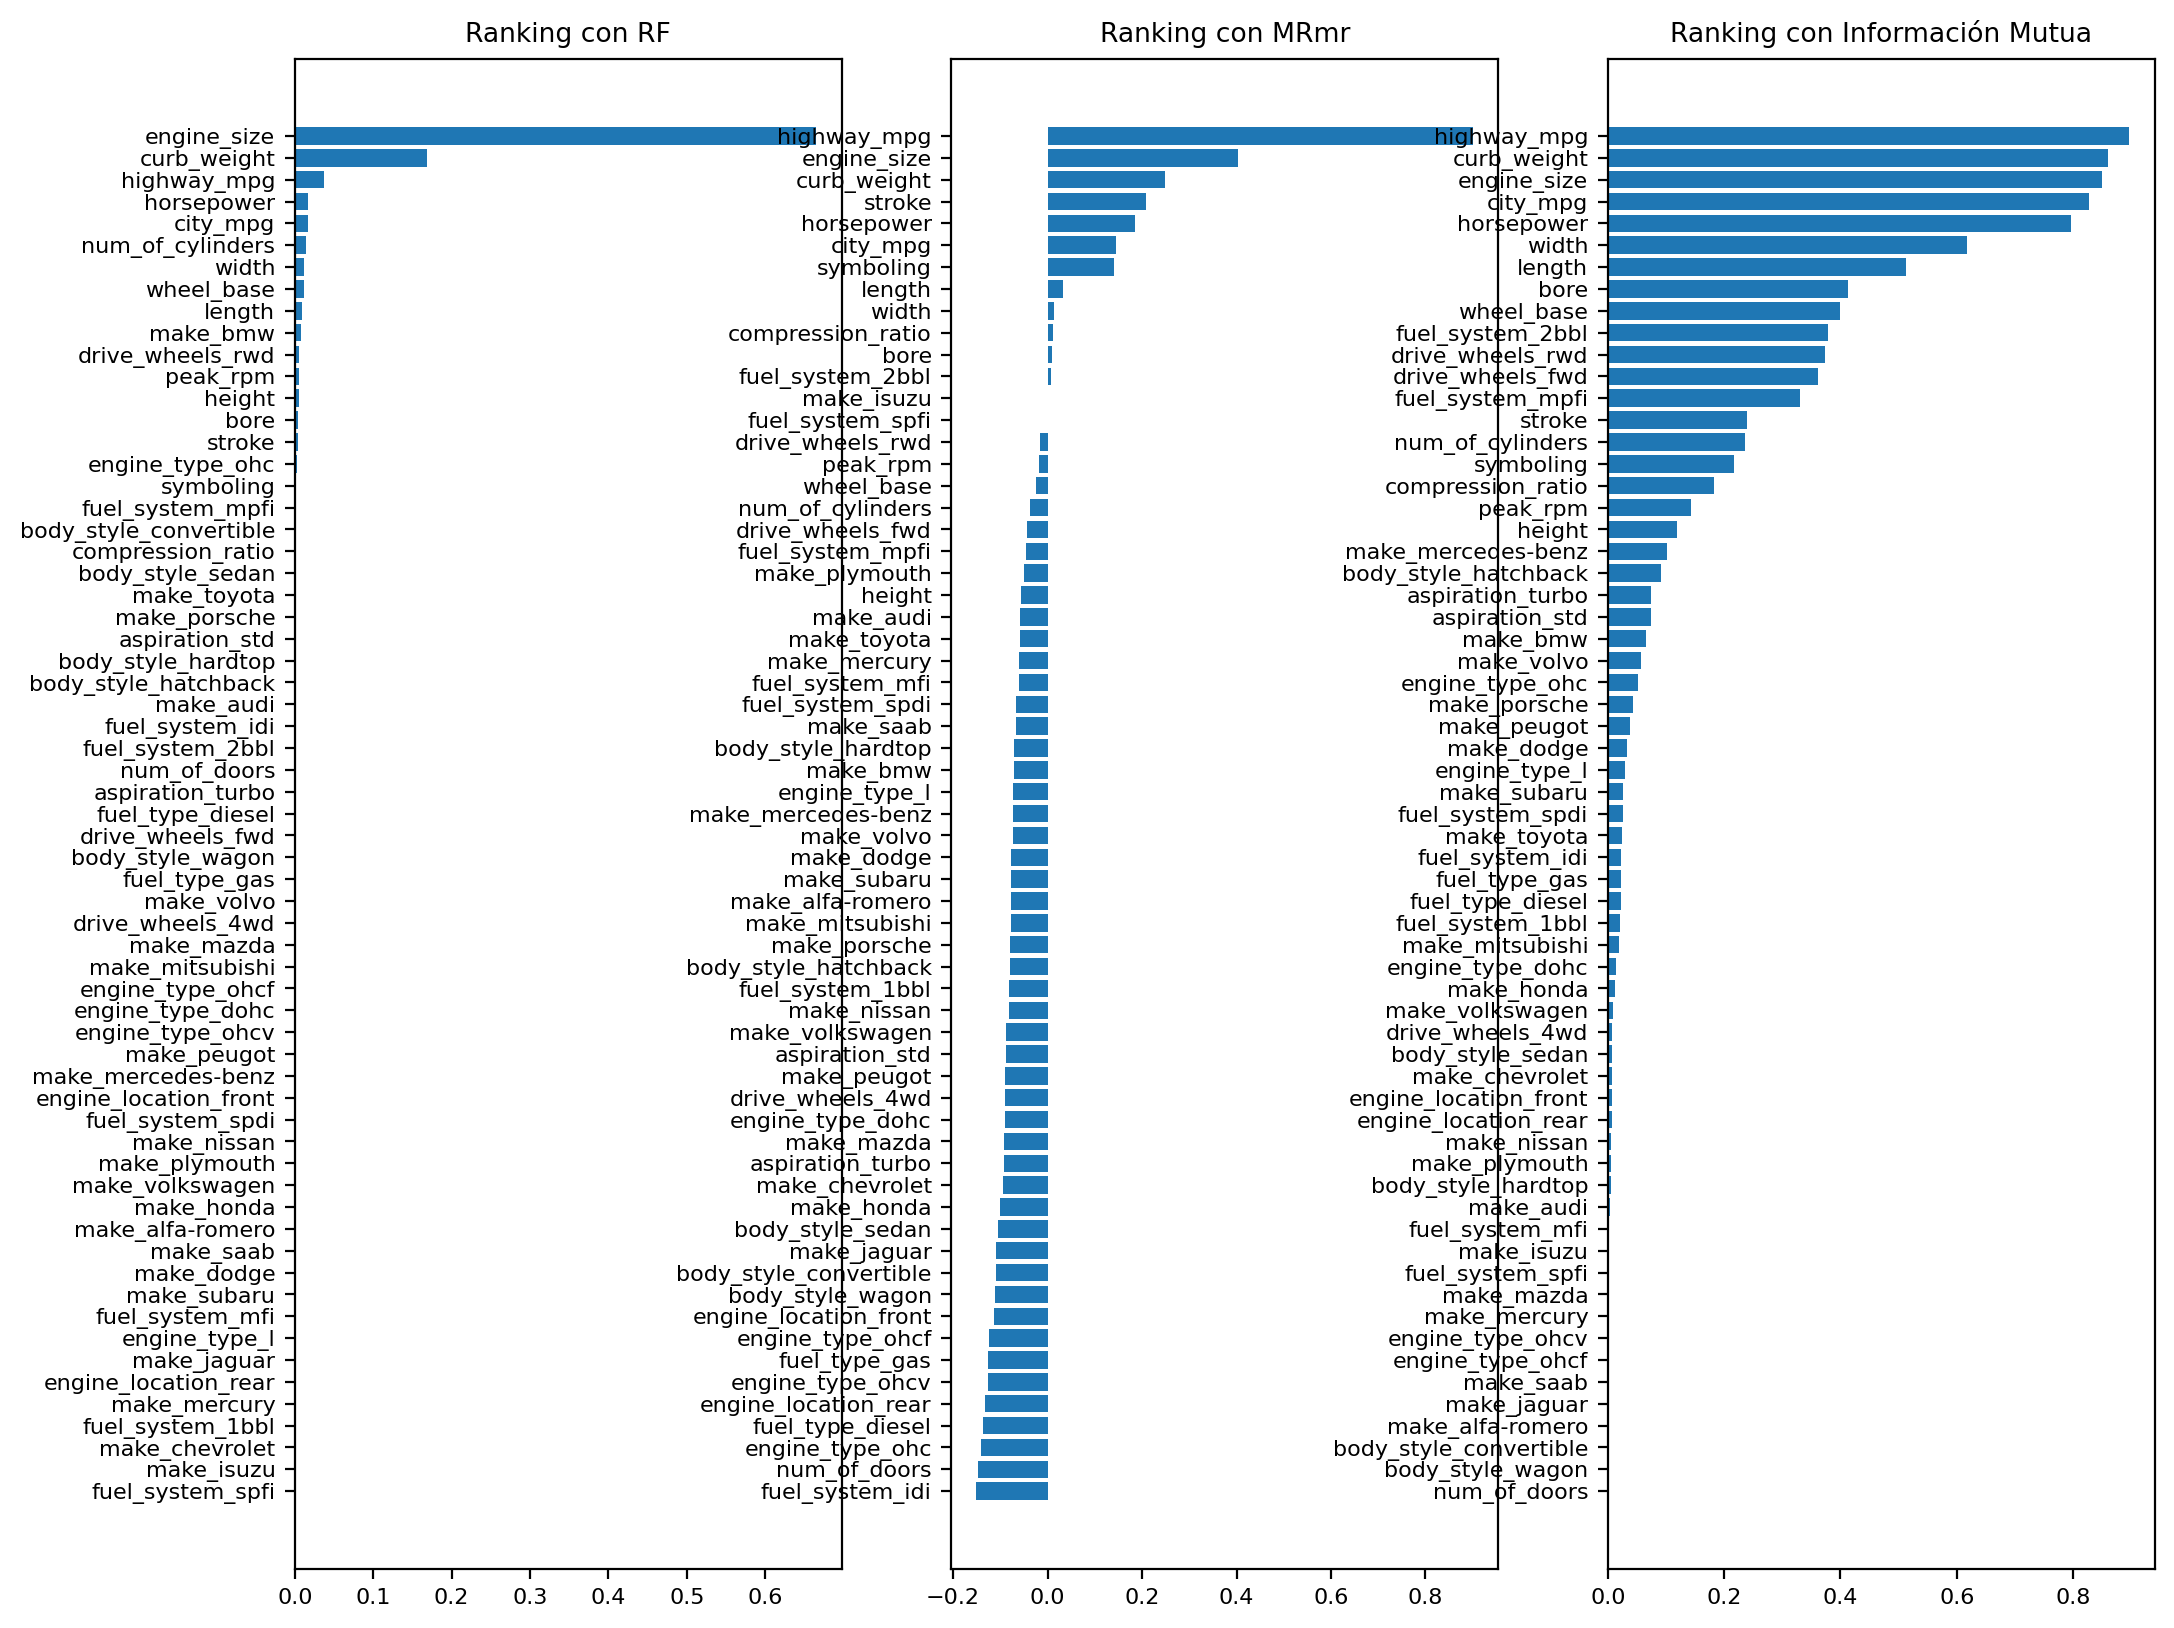

In [162]:
plt.figure(dpi=100, figsize=(12, 10))
plt.subplot(1,3,1)
plt.rc('ytick', labelsize=8) 
plot_utility_scores(ranking_RF, title="Ranking con RF")
plt.subplot(1,3,2)
plot_utility_scores(mi_scores_MRmr, title="Ranking con MRmr")
plt.subplot(1,3,3)
plot_utility_scores(mi_scores, title="Ranking con Información Mutua")

Tenga en cuenta que esta aproximación no hace estrictamente una selección de características, ya que la RF utiliza en realidad todas las características en su modelo; sin embargo, este enfoque proporciona un ranking de características durante el entrenamiento de RF que luego podemos usar para entrenar nuestro modelo

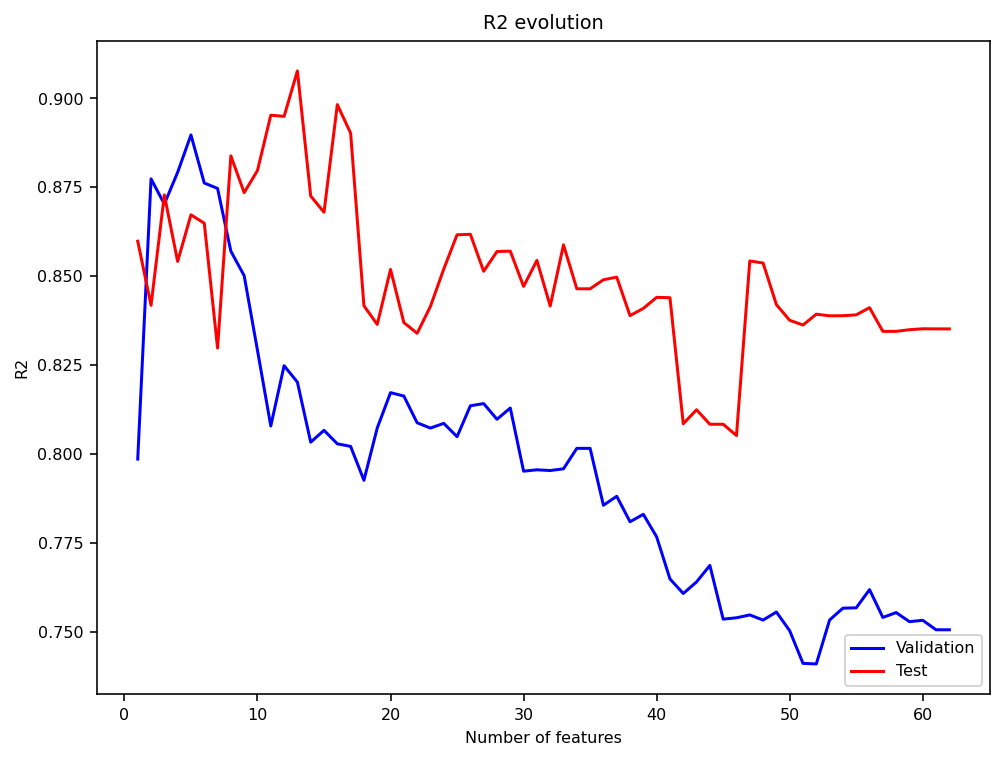

Number of features:  5
The test R2 is  0.87


In [163]:
# Define the range of features to explore
rang_feat = np.arange(1, X.shape[1]) 
[R2_val, R2_test] = R2_evolution(X_train[:, ind_rel_feat], Y_train, X_test[:, ind_rel_feat], Y_test, rang_feat)

# Plot the results
plt.figure()
plot_R2_evolution(rang_feat, R2_val, R2_test)
plt.show()

# Find the CV number of features
pos_max = np.argmax(R2_val)
num_feat = rang_feat[pos_max]
test_R2 = R2_test[pos_max]

print('Number of features:  %d' %(num_feat))
print("The test R2 is  %2.2f" %(test_R2))

### Regularización L1 

Muchos modelos de ML utilizan términos de regularización para evitar el sobreajuste del modelo. Mientras que la regularización más común es la L2, la regularización L1 hace que algunos de los coeficientes se anulen. Por lo tanto, la regularización L1 aplicada a modelos lineales hace una selección de características. Por esta razón, esta regularización se conoce como LASSO (Least Absolute Shrinkage and Selection Operator).

Para analizar esta propiedad, consideremos un modelo de regresión lineal regularizada, con regularizaciones L2 (Ridge Regression) y L1 (Lasso). Para ello, reescribamos sus formulaciones como un problema de optimización de mínimos cuadrados más una restricción, es decir,

* **Ridge Regression**:

$$\mathbf{w}^* = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{i=1}^{N} (y^{(i)}-\mathbf{w}^T\mathbf{x}^{(i)})^2 $$
$$ {\rm s.t.} \sum_{j=1}^{D} {w}_j^2 \leq t$$

* **Lasso Regression**:

$$\mathbf{w}^*= \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{i=1}^{N} (y^{(i)}-\mathbf{w}^T\mathbf{x}^{(i)})^2 $$
$$ {\rm s.t.} \sum_{j=1}^{D} | w_j| \leq t$$

De esta manera podemos ver que estos problemas están realmente minimizando el error cuadrático medio y, al mismo tiempo, están forzando que los valores de $\mathbf{w}$ estén dentro de la región definida por la regularización. En el caso de L2, esta regularización fuerza que $\mathbf{w}$ caiga dentro de una esfera de radio $\sqrt{t}$ y en el caso de L1 esta región es un diamante de lado $\sqrt{2}t$. La siguiente figura muestra estos problemas de optimización para un problema bidimensional (Ridge Regression a la izquierda y Lasso a la derecha).

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Regression/vL1_l2.png" width="50%" > 


Obsérvese que ambos métodos encuentran la solución óptima cuando los contornos elípticos (error cuadrático medio) cortan a la región definida por la regularización. Sin embargo, la restricción L1 tiene esquinas y cuando la solución cae en una esquina, el valor de algunos $w_j$ se hace cero. Cuando hay muchas dimensiones de entrada, el diamante se convierte en un romboide con muchas esquinas, aristas planas y caras, lo que aumenta las posibilidades de que los parámetros estimados se anulen.



El código de la siguiente celda analiza las propiedades de la regularización L1 como selector de características para un modelo de regresión lineal. En particular, utiliza la implementación dada por el método `Lasso`.

A diferencia de los métodos anteriores, aquí no podemos obtener un ranking de  variables. En este caso, tenemos que barrer el valor del parámetro de regularización (`alpha`) para obtener una mayor (o menor) dispersión del vector de pesos. 


In [164]:
from sklearn.linear_model import Lasso

# Defining some useful variables to save results
R2_test = []
num_feat = []

# Defining the range of C values to explore
rang_alpha = np.logspace(-2, 2, 20)

for i, alpha in enumerate(rang_alpha):
    # Define and train LASSO
    model = Lasso(alpha=alpha, max_iter=50000)
    model.fit(X_train, Y_train)
    
    # Compute the number of selected features (coef_l1 contains zeros due to the
    # L1 sparsity inducing norm)
    coef_l1 = model.coef_
    num_feat.append(np.sum(coef_l1 == 0))
    
    # Compute accuracies
    R2_test.append(model.score(X_test, Y_test))


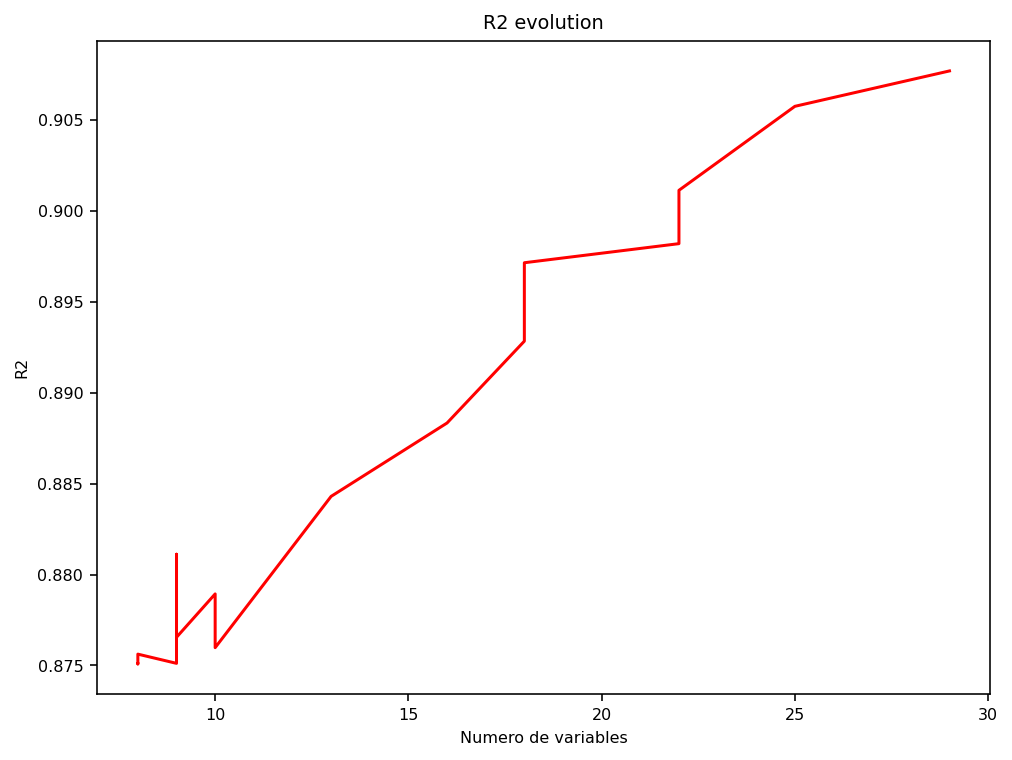

In [165]:
# Plot the accuracy curves
plt.figure()
num_feat = np.array(num_feat)
R2_test = np.array(R2_test)
id_sort = np.argsort(num_feat)
plt.plot(num_feat[id_sort], R2_test[id_sort], "r", label="test")
plt.xlabel("Numero de variables")
plt.ylabel("R2")
plt.title('R2 evolution')
plt.show()

En este caso no está tan claro definir el ranking de variables, pero directamente aplicando un GridSearch podemos seleccionar el valor de `alpha` y obtener de una vez el regresor junto con las variables seleccionadas. 

In [166]:
# Defining the range of C values to explore
param_grid = {
    'alpha': rang_alpha
    }

model = Lasso(max_iter=1e5)
grid= GridSearchCV(model, param_grid, cv=10)
grid.fit(X_train, Y_train)
R2_test = grid.score(X_test, Y_test)

print(grid.best_params_)

coef_l1 = grid.best_estimator_.coef_

print('Número de variables seleccionadas:  %d' %(np.sum(coef_l1 == 0)))
print("Valor de R2 en test  %2.2f" %(R2_test))


{'alpha': 100.0}
Número de variables seleccionadas:  29
Valor de R2 en test  0.91


Como vemos, es el modelo que mejor prestaciones obtienen aunque a costa de usar un mayor número de variables. No obstante, no debemos olvidar que la limitación del Lasso es que solo nos proporciona modelos lineales y solo selecciona variables relacionadas linealmente con la salida.